# Encoder - Decoder  https://kddseq2seq.com/

In [1]:
!pip install -q ktext
!pip install -q annoy

You should consider upgrading via the 'C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\ProgramData\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import json
import os
from urllib.request import urlopen
import tensorflow as tf
import glob
import unicodedata
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from annoy import AnnoyIndex
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, BatchNormalization, Dropout, Flatten, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import regularizers
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from ktext.preprocess import processor
import joblib
import numpy as np
import pandas as pd
import random
import glob
from tqdm import tqdm

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
Using TensorFlow backend.


In [2]:
print("gpu:{}".format(tf.test.gpu_device_name()))

gpu:/device:GPU:0


# Datasets

In [3]:
with open('', 'r', encoding="utf-8") as f:
    lines = json.load(f)
source_docs = [line['noticia'] for line in lines] #snippet
target_docs = [line['resumen'] for line in lines] #intent

In [3]:
docs = ['']
source_docs = []
target_docs = []

for doc in docs:
    with open(doc, 'r', encoding="utf-8") as f:
        lines = json.load(f)
        source_docs.extend([line['noticia'] for line in lines])
        target_docs.extend([line['resumen'] for line in lines])

In [31]:
docs = ['']
train_source_docs = []
train_target_docs = []
test_docs = []

for doc in docs:
    with open(doc, 'r',  encoding="utf-8") as f:
        lines = json.load(f)
        train_source_docs.extend([line['noticia'] for line in lines])
        train_target_docs.extend([line['resumen'] for line in lines])
        test_docs.extend([line['resumen'] for line in lines if line['resumen']])

In [5]:
with open('', 'r',  encoding="utf-8") as f:
    lines = json.load(f)
test_source_docs = [line['noticia'] for line in lines]
test_target_docs = [line['resumen'] for line in lines]

In [7]:
source_docs = source_docs[:50]
target_docs = target_docs[:50]

In [7]:
source_docs = source_docs[-10:]
target_docs = target_docs[-10:]

In [7]:
source_docs = source_docs[20:30]
target_docs = target_docs[20:30]

In [45]:
def clean_currency(lines):
  lines_list = lines.splitlines()
  # print(lines_list)
  # print("------------------------")
  ans = lines_list.copy()
  for i in range(len(ans)):#se leen todas las lineas
    words = ans[i].split(" ") #se separa por espacios para que quede una lista de palabras
    for j in range(len(words)):#se lee cada palabra de la linea
      word = words[j].strip()
      k = 1
      is_currency = False
      is_interrog = False
      is_qmarks = False
      while(k+1 < len(word) and not is_currency):
        if( (word[k-1].islower() and word[k] == '.' and word[k+1].isupper() ) or (word[k-1].islower() and word[k] == '.' and word[k+1].islower()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].islower()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].isupper()) or (word[k-1].isdigit() and word[k] == '.' and word[k+1].isupper()) or (word[k-1].isdigit() and word[k] == '.' and word[k+1].islower()) or (word[k-1].islower() and word[k] == '.' and word[k+1].isdigit()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].isdigit()) or (word[k-1] == '"' and word[k] == '.' and word[k+1].isupper()) or (word[k-1] == '"' and word[k] == '.' and word[k+1].islower()) or (word[k-1] == '"' and word[k] == '.' and word[k+1] == '"') or (word[k-1].isdigit() and word[k] == '.' and word[k+1] == '"') or (word[k-1].isupper() and word[k] == '.' and word[k+1] == '"') or word[k-1] == "'" and word[k] == '.' and word[k+1].isupper() or word[k-1] == "'" and word[k] == '.' and word[k+1].islower() or word[k-1].islower() and word[k] == '.' and word[k+1] == "'" or word[k-1].isupper() and word[k] == '.' and word[k+1] == "'" or word[k-1] == "'" and word[k] == '.' and word[k+1].isdigit() or word[k-1] == "'" and word[k] == '.' and word[k+1] == "'" or word[k-1].islower() and word[k] == '.' and word[k+1] == "\x89" or word[k-1].isupper() and word[k] == '.' and word[k+1] == "\x89" or word[k-1].isdigit() and word[k] == '.' and word[k+1] == "\x89" or word[k-1] == ')' and word[k] == '.' and word[k+1].isupper() or word[k-1] == ')' and word[k] == '.' and word[k+1].islower() or word[k-1].islower() and word[k] == '.' and word[k+1] == '(' or word[k-1].isupper() and word[k] == '.' and word[k+1] == '(' or word[k-1] == ')' and word[k] == '.' and word[k+1].isdigit() or word[k-1].isdigit() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1].islower() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1].isupper() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1] == '}' and word[k] == '.' and word[k+1].isupper() or word[k-1] == '}' and word[k] == '.' and word[k+1].islower() or word[k-1] == '}' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == ']' and word[k] == '.' and word[k+1].isupper() or word[k-1] == ']' and word[k] == '.' and word[k+1].islower() or word[k-1] == ']' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == '%' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == '%' and word[k] == '.' and word[k+1].islower() or word[k-1] == '%' and word[k] == '.' and word[k+1].isupper() ):
          is_currency = True
        if( word[k-1].islower() and word[k] == '?' and word[k+1].isupper() or word[k-1].islower() and word[k] == '?' and word[k+1].islower() ):
          is_interrog = True
        if( word[k-1] == '.' and word[k] == '"' and word[k+1].isupper() ):
          is_qmarks = True
        k += 1
      if(is_currency):
        word = word.replace(".",". ",1)
      if(is_interrog):
        word = word.replace("?","? ",1)
      if(is_qmarks):
        word = word.replace('"','" ',1)
      words[j] = str(word)
    ans[i] = " ".join(words) #se vuelve a reestablecer la linea con un solo espacio entre cada palabra
  return ans


def replace_special_characters_in_words(text_list):
    cleaned_text_list = []
    for text in text_list:
        words = text.split()  # Dividir el texto en palabras
        cleaned_words = []
        for word in words:
            cleaned_word = word.replace('\x89ÛÓ', ' ').replace('\n\n', '.').replace('\n', '.').replace('\x89Û¢', '').replace('\x89Ûª', '').replace('\'', '').replace('\x89ÛÏ', '').replace('\x89Û\x9d', '').replace('\x89ÐÊ', '').replace('\\\\', '').replace('\\', '').replace('\x89Û÷', '').replace('\x89Û_', '').replace('\x89ÏÒ', '')  # Encadenar los reemplazos en una sola línea
            
            cleaned_words.append(cleaned_word)
        cleaned_text = ' '.join(cleaned_words)  # Unir las palabras nuevamente en un texto
        cleaned_text_list.append(cleaned_text)
    return cleaned_text_list


def make_labels(news_list): #funcion que crea el label que representa cuales oraciones del resumen están dentro de la noticia
    all_document_sentences = []

  #if(title):
    #news_text = news_list[1:] #saltarse la linea del titulo #solo lo uso con los datasets que tienen titulo como por ejm. BBC
    
    for news_text in news_list:
        # print("Noticias clean_currency:", news_text)
        # print("----------------------------")
        news_text_cleaned = clean_currency(news_text)
        # print("Cleaned Currency:", news_text_cleaned)
        # print("----------------------------")
        news_text_cleaned_special = replace_special_characters_in_words(news_text_cleaned)
        # print("----------------------------")
        # print("Cleaned Special Characters:", news_text_cleaned_special)

        for doc_sent in news_text_cleaned_special:
            all_document_sentences.append(doc_sent)

    # print("All Document Sentences:", all_document_sentences)
    return all_document_sentences

In [11]:
train_source_docs = make_labels(train_source_docs)
train_target_docs = make_labels(train_target_docs)

In [12]:
test_source_docs = make_labels(test_source_docs)
test_target_docs = make_labels(test_target_docs)

In [46]:
source_docs = make_labels(source_docs)
target_docs = make_labels(target_docs)

In [14]:
print(source_docs[:2])

['President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaign and widespread predictions of a recession cutting taxes now would do more harm than good. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals. Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnt stand much chance this year unless there is a larger tax bill to which they can be attached.', 'The na

#### Keras Text Pre-Processing Primer

Now that we have gathered the data, we need to prepare the data for the modeling. Before jumping into the code, let’s warm up with a toy example of two documents:

```
[“The quick brown fox jumped over the lazy dog 42 times.”, “The dog is lazy”]
```

Below is a rough outline of the steps I will take in order to pre-processes this raw text:

**1. Clean text:** in this step, we want to remove or replace specific characters and lower case all the text. This step is discretionary and depends on the size of the data and the specifics of your domain. In this toy example, I lower-case all characters and replace numbers with *number* in the text. In the real data, I handle more scenarios.

[“the quick brown fox jumped over the lazy dog *number* times”, “the dog is lazy”]


**3. Tokenize:** split each document into a list of words

```
[[‘the’, ‘quick’, ‘brown’, ‘fox’, ‘jumped’, ‘over’, ‘the’, ‘lazy’, ‘dog’, ‘*number*’, ‘times’], [‘the’, ‘dog’, ‘is’, ‘lazy’]]
```

**4. Build vocabulary:** You will need to represent each distinct word in your corpus as an integer, which means you will need to build a map of token -> integers. Furthermore, I find it useful to reserve an integer for rare words that occur below a certain threshold as well as 0 for padding (see next step). After you apply a token -> integer mapping, your data might look like this:

```
[[2, 3, 4, 5, 6, 7, 2, 8, 9, 10, 11], [2, 9, 12, 8]]
```

**5. Padding:** 5. Padding: You will have documents that have different lengths. There are many strategies on how to deal with this for deep learning, however for this tutorial I will pad and truncate documents such that they are all transformed to the same length for simplicity. You can decide to pad (with zeros) and truncate your document at the beginning or end, which I will refer to as “pre” and “post” respectively. After pre-padding our toy example, the data might look like this:

```
[[2, 3, 4, 5, 6, 7, 2, 8, 9, 10, 11], [0, 0, 0, 0, 0, 0, 0, 2, 9, 12, 8]]
```

A reasonable way to decide your target document length is to build a histogram of document lengths and choose a sensible number. (Note that the above example has padded the data in front but we could also pad at the end. We will discuss this more in the next section).

Inspect the raw text of source and target documents:

Source docs:


In [17]:
for x in source_docs[:10]:
  print(x)

President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaign and widespread predictions of a recession cutting taxes now would do more harm than good. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals. Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnt stand much chance this year unless there is a larger tax bill to which they can be attached.
The nation 

Target docs:

In [18]:
target_docs[:10]

['President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals.',
 'The nation racked up a record $3,1 billion trade deficit last month, the Commerce Department reported yesterday, but officials cautioned that the deficits size was exaggerated by the East and Gulf Coast dock strikes. Nevertheless, it was the 17th month in a row that the United States has imported more than it has exported. this year, is contributing to the decline In the value of the dollar abroad.',
 'A mild stock rally 

In order to pre-process this data, we will use the [`ktext` package](https://github.com/hamelsmu/ktext).   `ktext` helps accomplish the pre-processing steps outlined in the previous section. This library is a thin wrapper around keras and spacy text processing utilities, and leverages python process-based-threading to speed things up. It also chains all of the pre-processing steps together and provides a bunch of convenience functions. Warning: this package is under development so use with caution outside this tutorial (pull requests are welcome!). To learn more about how this library works, look at this [tutorial](https://github.com/hamelsmu/ktext/blob/master/notebooks/Tutorial.ipynb) (but for now I suggest reading ahead).

In [19]:
# proc = processor(heuristic_pct_padding=.95, keep_n=30000) #antes keep_n =5000, heuristic_pct_padding = .7
# vecs = proc.fit_transform(target_docs)

In [13]:
#Pruebo haciendolo con target_docs ** 4/28/24
proc = processor(heuristic_pct_padding=.95, keep_n=50000) #antes keep_n =5000, heuristic_pct_padding = .7 // antes 1 (1-27-24) y keep n 50000
vecs = proc.fit_transform(target_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [ ]:
#prueba
#vecs = proc.fit_transform([" President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals."])

In [102]:
print(len(vecs[0]))

110


In [35]:
pip install ppyaml h5py

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml


In [103]:
print(vecs)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 13 14 15 16 17 18 19 20 21 22
   6 23 24 25 26 27  2 28  7 29  4 30 31  8  9 32 33 34 35 36 10 37 38 39
  40  3 41 42  2 43 44 45 11 46 10 47 48 49 50 51  7  3 52 53 54 55 56 11
   8  9 57 58  4  3 59  4 60 61  2 12 62 63 64 65 66  5 67  6  3 68 69 70
  71  2 72  5 73 74 75 76  5 77 78  2 12 79]]


In [24]:
#Pruebo haciendolo con target_docs
proc = processor(heuristic_pct_padding=.95, keep_n=50000) #antes keep_n =5000, heuristic_pct_padding = .7 // antes 1 (1-27-24) y keep n 50000
vecs = proc.fit_transform(target_docs)

UnboundLocalError: local variable 'transformed_data' referenced before assignment

In [24]:
#Pruebo haciendolo con target_docs
proc = processor(heuristic_pct_padding=.7, keep_n=50000) #antes keep_n =5000, heuristic_pct_padding = .7 // antes 1 (1-27-24)
vecs = proc.fit_transform(source_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [25]:
#prueba con source 1-27-24
assert vecs.shape[0] == len(source_docs)

In [14]:
assert vecs.shape[0] == len(target_docs)

The above code cleans, tokenizes, and applies pre-padding and post-truncating such that each document length is equal to the 70th percentile of document lengths, which is an arbitrary choice. I made decisions about padding length by studying histograms of document length provided by ktext. Furthermore, only the top 5,000 words in the vocabulary are retained and remaining words are set to the index 1 which correspond to rare words (this was another arbitrary choice).

Below is an example where tokens are mapped to integers.

In [22]:
#prueba
print('original list: ', source_docs[0])
print('tokenized list: ', vecs[0])

original list:  President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaign and widespread predictions of a recession cutting taxes now would do more harm than good. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals. Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnt stand much chance this year unless there is a larger tax bill to which they can be attac

In [15]:
print('original list: ', target_docs[0])
print('tokenized list: ', vecs[0])

original list:  President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals.
tokenized list:  [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0    67   859    93   823    23    36  1182    39    56   161
     4  6634   133    31   584    26   107 12716    13   291     3    68
   336   835    57   983   984    17   305  4411     8  4771   400  1714
  7726     6   674  1942   107   860   330 12717     2    42     8   101
    35   811    14  1141    13   

In [23]:
print(len(vecs))

111702


We can see the most common words here, by calling the `token_count_pandas()` method.

In [24]:
proc.token_count_pandas().head(200)

,count
the,538684
of,226242
to,220368
a,213974
in,206458
...,...
presidential,4710
leader,4705
islamic,4678
order,4608


Furthermore, the documents in our corpus have different lengths. By setting `hueristic_pct_padding=.7`, `ktext` will truncate and pad all sequences to the 70th percentile length. However, it can be useful to sanity check a histogram of lengths. We inspect the `document_length_stats` property below which displays a histogram of document lengths.

In [25]:
proc.document_length_stats

,bin,doc_count,cumsum_pct
36,0,15500,0.138762
47,5,1063,0.148278
34,10,3701,0.181411
35,15,2226,0.201339
27,20,1708,0.216630
...,...,...,...
110,1180,1,0.999964
131,1190,1,0.999973
124,1330,1,0.999982
81,1375,1,0.999991


It is useful to keep track of the maximum length and the unique number of tokens in the corpus for later purposes.

In [16]:
vocab_size = max(proc.id2token.keys()) + 1
max_length = proc.padding_maxlen

print('vocab size: ', vocab_size)
print('max length allowed for documents: ', max_length)

vocab size:  23261
max length allowed for documents:  110


In [12]:
#prueba
vocab_size = max(proc.id2token.keys()) + 1
max_length = proc.padding_maxlen

print('vocab size: ', vocab_size)
print('max length allowed for documents: ', max_length)

vocab size:  23261
max length allowed for documents:  110


Prepare training data for language model.

In [27]:
sequences = []
for arr in tqdm(vecs):
    non_zero = (arr != 0).argmax()
    for i in range(non_zero, len(arr)):
        sequences.append(arr[:i+1])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)

100%|██████████| 111702/111702 [00:05<00:00, 20348.47it/s]


In [17]:
#prueba
sequences = []
for arr in tqdm(vecs):
    non_zero = (arr != 0).argmax()
    for i in range(non_zero, len(arr)):
        sequences.append(arr[:i+1])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)

100%|██████████| 7326/7326 [00:00<00:00, 46593.27it/s]


In [28]:
print(X.shape)

(11131803, 189)


In [18]:
print(X.shape)

(505170, 109)


In [29]:
print(source_docs[0])

President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaign and widespread predictions of a recession cutting taxes now would do more harm than good. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals. Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnt stand much chance this year unless there is a larger tax bill to which they can be attached.


In [30]:
print(y.shape)

(11131803,)


In [33]:
def model_arc(vocab_size_fix, emb_var, vocab_size_var, act_var, drop_var, blocks): #esta es la misma de cambiar los parametros pero para probar varias cosas al tiempo ** 4/28/24
    i = Input(shape=(max_length-1,))
    x = Embedding(vocab_size_fix, emb_var, input_length=max_length-1)(i)
    x = LSTM(emb_var, return_sequences=True)(x)
    for k in range(blocks):
        x = Dense(emb_var, act_var)(x)
        x = Dropout(drop_var)(x)
    last_timestep = Lambda(lambda x: x[:, -1, :])(x)
    #last_timestep = Dense(vocab_size_var, act_var)(last_timestep)
    #last_timestep = Dropout(drop_var)(last_timestep)
    last_timestep = Dense(vocab_size_fix, activation='softmax')(last_timestep)
    model = Model(i, last_timestep)
    
    return model

In [19]:
#es la que se esta usando actualmente para el grid search 7-12-24
#sin el vocab_size_var pues ya no se usa

def model_arc(vocab_size_fix, emb_var, act_var, drop_var, blocks): #esta es la misma de cambiar los parametros pero para probar varias cosas al tiempo ** 4/28/24
    i = Input(shape=(max_length-1,))
    x = Embedding(vocab_size_fix, emb_var, input_length=max_length-1)(i)
    x = LSTM(emb_var, return_sequences=True)(x)
    for k in range(blocks):
        x = Dense(emb_var, act_var)(x)
        x = Dropout(drop_var)(x)
    last_timestep = Lambda(lambda x: x[:, -1, :])(x)
    #last_timestep = Dense(vocab_size_var, act_var)(last_timestep)
    #last_timestep = Dropout(drop_var)(last_timestep)
    last_timestep = Dense(vocab_size_fix, activation='softmax')(last_timestep)
    model = Model(i, last_timestep)
    
    return model

In [ ]:
#la anterior que se usaba con vocab_size_var (ya no existe vocab_size)
def model_arc(vocab_size_fix, emb_var, vocab_size_var, act_var, drop_var, blocks): #esta es la misma de cambiar los parametros pero para probar varias cosas al tiempo ** 4/28/24
    i = Input(shape=(max_length-1,))
    x = Embedding(vocab_size_fix, emb_var, input_length=max_length-1)(i)
    x = LSTM(emb_var, return_sequences=True)(x)
    for k in range(blocks):
        x = Dense(emb_var, act_var)(x)
        x = Dropout(drop_var)(x)
    last_timestep = Lambda(lambda x: x[:, -1, :])(x)
    #last_timestep = Dense(vocab_size_var, act_var)(last_timestep)
    #last_timestep = Dropout(drop_var)(last_timestep)
    last_timestep = Dense(vocab_size_fix, activation='softmax')(last_timestep)
    model = Model(i, last_timestep)
    
    return model

In [21]:
#estructura de lenguaje con la que se han hecho todas las pruebas anteriores, de cambio de parametros, es la mejorada de la que sigue del (***), numeros fijos para pruebas individuales, se agregó lo de los bloques, es la ultima modificacion 7-12-24
i = Input(shape=(max_length-1,))
x = Embedding(vocab_size, 256, input_length=max_length-1)(i)
x = LSTM(256, return_sequences=True)(x)
x = Dense(32, activation='tanh')(x)
x = Dropout(0.25)(x)
last_timestep = Lambda(lambda x: x[:, -1, :])(x)
#last_timestep = Dropout(0.25)(last_timestep)
last_timestep = Dense(vocab_size, activation='softmax')(last_timestep)
# last_timestep = Dropout(0.4)(last_timestep)
model = Model(i, last_timestep)
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [32]:
#estructura de lenguaje con la que probaré cambiar parámetros (***) prueba 2-12-24, sin bloques
#no tiene dropout
i = Input(shape=(max_length-1,))
x = Embedding(vocab_size, 256, input_length=max_length-1)(i)
x = LSTM(256, return_sequences=True)(x)
x = Dense(256, activation='tanh')(x)
last_timestep = Lambda(lambda x: x[:, -1, :])(x)
#last_timestep = Dropout(0.25)(last_timestep)
last_timestep = Dense(vocab_size, activation='softmax')(last_timestep)
#last_timestep = Dropout(0.25)(last_timestep)
model = Model(i, last_timestep)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 109, 256)          5954816   
_________________________________________________________________
lstm (LSTM)                  (None, 109, 256)          525312    
_________________________________________________________________
dense (Dense)                (None, 109, 256)          65792     
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23261)             5978077   
Total params: 12,523,997
Trainable params: 12,523,997
Non-trainable params: 0
_________________________________________________

In [29]:
#primera de todas, no se usa, las actuales contienen lo de esta
#LSTM 512
i = Input(shape=(max_length-1,))
x = Embedding(vocab_size, 256, input_length=max_length-1)(i)
x = LSTM(256, return_sequences=True)(x)
last_timestep = Lambda(lambda x: x[:, -1, :])(x)
last_timestep = Dense(vocab_size, activation='softmax')(last_timestep)
model = Model(i, last_timestep)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 109, 256)          5954816   
_________________________________________________________________
lstm (LSTM)                  (None, 109, 256)          525312    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 23261)             5978077   
Total params: 12,458,205
Trainable params: 12,458,205
Non-trainable params: 0
_________________________________________________________________


In [17]:
#batch size 500 //con 32, 30 epocas, patience=20USN
model_filepath = "/Users/Nata/Documents/saved_models_embs/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stop = EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)
callbacks_list = [checkpoint, early_stop]

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.1, callbacks = callbacks_list)

Epoch 1/30
13517/13517 [==============================] - 248s 18ms/step - loss: 5.3270 - accuracy: 0.1829 - val_loss: 4.9144 - val_accuracy: 0.2138

Epoch 00001: val_accuracy improved from -inf to 0.21377, saving model to /Users/Nata/Documents/saved_models_embs\model-01-0.2138.hdf5
Epoch 2/30
13517/13517 [==============================] - 240s 18ms/step - loss: 4.6421 - accuracy: 0.2315 - val_loss: 4.7190 - val_accuracy: 0.2318

Epoch 00002: val_accuracy improved from 0.21377 to 0.23184, saving model to /Users/Nata/Documents/saved_models_embs\model-02-0.2318.hdf5
Epoch 3/30
13517/13517 [==============================] - 243s 18ms/step - loss: 4.3293 - accuracy: 0.2530 - val_loss: 4.6955 - val_accuracy: 0.2347

Epoch 00003: val_accuracy improved from 0.23184 to 0.23471, saving model to /Users/Nata/Documents/saved_models_embs\model-03-0.2347.hdf5
Epoch 4/30
13517/13517 [==============================] - 248s 18ms/step - loss: 4.0894 - accuracy: 0.2702 - val_loss: 4.7261 - val_accuracy: 

In [32]:
#**6/2/24, 100 antes ahora 30
params = [
           [50002, 8, 'tanh', 0.5, 0.0001, 1]
           # [50002, 8, 'tanh', 0.25, 0.0001, 1]
           # [50002, 8, 'tanh', 0.75, 0.0001, 1],
           # [50002, 16, 'tanh', 0.5, 0.0001, 1],
           # [50002, 16, 'tanh', 0.25, 0.0001, 1],
           # [50002, 16, 'tanh', 0.75, 0.0001, 1],
           # [50002, 32, 'tanh', 0.5, 0.0001, 1],
           # [50002, 32, 'tanh', 0.25, 0.0001, 1],
           # [50002, 32, 'tanh', 0.75, 0.0001, 1]
           #[],
           #[],
           #[]

    
         ]

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def grid_search_language(params):
    for param in params:
        print(param[0], param[1], param[2], param[3], param[4], param[5])
        vocab_size_fix, emb_var, act_var, drop_var, blocks = param[0], param[1], param[2], param[3], param[5]
        learning_rate = param[4]
        
        model = model_arc(vocab_size_fix, emb_var, act_var, drop_var, blocks)
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = param[5]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X, y, epochs=100,batch_size=32,validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 100, restore_best_weights = True)])
        
        model_filepath = f"/Users/Nata/Documents/saved_models_language-{emb_var}-{drop_var}/model_weights"
        model.save_weights(model_filepath)
        
    
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')

        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        
        print("--------------------")
        print("vocab_size_fix: ", vocab_size_fix, "emb_var: ", emb_var, "act_var: ", act_var, "drop_var: ", drop_var, "learning_reate: ", learning_rate, "cantidad de bloques: ", blocks) 
        print("min val_loss: ", min(history.history['val_loss']), "accuracy en min val_loss: ", history.history['val_accuracy'][np.argmin(history.history['val_loss'])])
        print("epochs: ", len(history.history['val_loss']))
        
        

In [40]:
#**5/10/24, 100 antes ahora 30 NUEVO 5-29-2024 *tiene el checkpoint
params = [
           [50002, 8, 'tanh', 0.5, 0.0001, 1]
           # [50002, 8, 'tanh', 0.25, 0.0001, 1]
           # [50002, 8, 'tanh', 0.75, 0.0001, 1],
           # [50002, 16, 'tanh', 0.5, 0.0001, 1],
           # [50002, 16, 'tanh', 0.25, 0.0001, 1],
           # [50002, 16, 'tanh', 0.75, 0.0001, 1],
           # [50002, 32, 'tanh', 0.5, 0.0001, 1],
           # [50002, 32, 'tanh', 0.25, 0.0001, 1],
           # [50002, 32, 'tanh', 0.75, 0.0001, 1]
           #[],
           #[],
           #[]

    
         ]

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def grid_search_language(params):
    for param in params:
        print(param[0], param[1], param[2], param[3], param[4], param[5])
        vocab_size_fix, emb_var, act_var, drop_var, blocks = param[0], param[1], param[2], param[3], param[5]
        learning_rate = param[4]
        latest = tf.train.latest_checkpoint("/Users/Nata/Documents/saved_models_language-8-0.5")
        model = model_arc(vocab_size_fix, emb_var, act_var, drop_var, blocks)
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = param[5]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.load_weights(latest)
        history = model.fit(X, y, epochs=100,batch_size=32,validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 100, restore_best_weights = True)])
        
        model_filepath = f"/Users/Nata/Documents/saved_models_language2-{emb_var}-{drop_var}/model_weights"
        model.save_weights(model_filepath)
        
    
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')

        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        
        print("--------------------")
        print("vocab_size_fix: ", vocab_size_fix, "emb_var: ", emb_var, "act_var: ", act_var, "drop_var: ", drop_var, "learning_reate: ", learning_rate, "cantidad de bloques: ", blocks) 
        print("min val_loss: ", min(history.history['val_loss']), "accuracy en min val_loss: ", history.history['val_accuracy'][np.argmin(history.history['val_loss'])])
        print("epochs: ", len(history.history['val_loss']))
        
        

In [ ]:
#**4/28/24, 100 antes ahora 30 por probar 1 - primeras pruebas
params = [
           # [23261, 256, 500, 'relu', 0.5, 0.0001],
           # [23261, 256, 1000, 'relu', 0.5, 0.0001],
           # [23261, 256, 5000, 'relu', 0.5, 0.0001],
           # [23261, 256, 500, 'relu', 0.25, 0.0001],
           # [23261, 256, 1000, 'relu', 0.25, 0.0001],
           # [23261, 256, 5000, 'relu', 0.25, 0.0001],
           # [23261, 256, 500, 'relu', 0.75, 0.0001],
           # [23261, 256, 1000, 'relu', 0.75, 0.0001],
           # [23261, 256, 5000, 'relu', 0.75, 0.0001],
           # [23261, 256, 500, 'tanh', 0.5, 0.0001],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001],
           # [23261, 256, 5000, 'tanh', 0.5, 0.0001],
           # [50002, 256, 500, 'tanh', 0.25, 0.0001, 1],
           [50002, 8, 500, 'tanh', 0.5, 0.0001, 1],
           # [23261, 256, 1000, 'tanh', 0.25, 0.0001, 1],
           # [23261, 256, 5000, 'tanh', 0.25, 0.0001, 1],
           # [50002, 256, 5000, 'relu', 0.4, 0.0001, 1],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001, 1],
           # [23261, 256, 5000, 'tanh', 0.5, 0.0001, 1],
           # [50002, 256, 500, 'tanh', 0.25, 0.0001, 2],
           # [23261, 256, 1000, 'tanh', 0.25, 0.0001, 2],
           # [23261, 256, 5000, 'tanh', 0.25, 0.0001, 2],
           # [23261, 256, 5000, 'relu', 0.4, 0.0001, 2],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001, 2],
           # [23261, 256, 5000, 'tanh', 0.5, 0.0001, 2],
           # [23261, 256, 500, 'tanh', 0.25, 0.0001, 3],
           # [23261, 256, 1000, 'tanh', 0.25, 0.0001, 3],
           # [23261, 256, 5000, 'tanh', 0.25, 0.0001, 3],
           # [23261, 256, 5000, 'relu', 0.4, 0.0001, 3],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001, 3],
           # [23261, 256, 5000, 'tanh', 0.5, 0.0001, 3],
           # [23261, 256, 500, 'tanh', 0.25, 0.0001, 4],
           # [23261, 256, 1000, 'tanh', 0.25, 0.0001, 4],
           # [23261, 256, 5000, 'tanh', 0.25, 0.0001, 4],
           # [23261, 256, 5000, 'relu', 0.4, 0.0001, 4],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001, 4],
           # [23261, 256, 5000, 'tanh', 0.5, 0.0001, 4],
           # [23261, 256, 500, 'tanh', 0.25, 0.0001, 5],
           # [23261, 256, 1000, 'tanh', 0.25, 0.0001, 5],
           # [23261, 256, 5000, 'tanh', 0.25, 0.0001, 5],
           # [23261, 256, 5000, 'relu', 0.4, 0.0001, 5],
           # [23261, 256, 1000, 'tanh', 0.5, 0.0001, 5],
           # [50002, 256, 5000, 'tanh', 0.5, 0.0001, 5]
           # [23261, 256, 500, 'tanh', 0.75, 0.0001],
           # [23261, 256, 1000, 'tanh', 0.75, 0.0001],
           # [23261, 256, 5000, 'tanh', 0.75, 0.0001]
    
           #[],
           #[],
           #[]

    
         ]

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def grid_search_language(params):
    for param in params:
        print(param[0], param[1], param[2], param[3], param[4], param[5], param[6])
        vocab_size_fix, emb_var, vocab_size_var, act_var, drop_var, blocks = param[0], param[1], param[2], param[3], param[4], param[6]
        learning_rate = param[5]
        
        model = model_arc(vocab_size_fix, emb_var, vocab_size_var, act_var, drop_var, blocks)
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = param[5]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X, y, epochs=1,batch_size=32,validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])
        
        model_filepath = "/Users/Nata/Documents/saved_models_language/model-{emb_var}-{drop_var}.h5"
        
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')

        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        
        print("--------------------")
        print("vocab_size_fix: ", vocab_size_fix, "emb_var: ", emb_var, "vocab_size_var:", vocab_size_var, "act_var: ", act_var, "drop_var: ", drop_var, "learning_reate: ", learning_rate, "cantidad de bloques: ", blocks) 
        print("min val_loss: ", min(history.history['val_loss']), "accuracy en min val_loss: ", history.history['val_accuracy'][np.argmin(history.history['val_loss'])])
        print("epochs: ", len(history.history['val_loss']))

In [35]:
pip install ppyaml h5py

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml


50002 8 tanh 0.5 0.0001 1
Epoch 1/100
260902/260902 [==============================] - 7599s 29ms/step - loss: 67.7199 - accuracy: 0.1520 - val_loss: 81.0165 - val_accuracy: 0.2832
Epoch 2/100
260902/260902 [==============================] - 7346s 28ms/step - loss: 83.7691 - accuracy: 0.1579 - val_loss: 117.3262 - val_accuracy: 0.2722
Epoch 3/100
260902/260902 [==============================] - 7204s 28ms/step - loss: 109.5689 - accuracy: 0.1153 - val_loss: 169.4101 - val_accuracy: 0.3117
Epoch 4/100
260902/260902 [==============================] - 7172s 27ms/step - loss: 137.5494 - accuracy: 0.0819 - val_loss: 229.3528 - val_accuracy: 0.2708
Epoch 5/100
260902/260902 [==============================] - 7155s 27ms/step - loss: 167.9555 - accuracy: 0.0776 - val_loss: 289.9112 - val_accuracy: 0.2708
Epoch 6/100
260902/260902 [==============================] - 7188s 28ms/step - loss: 197.6932 - accuracy: 0.0777 - val_loss: 349.6196 - val_accuracy: 0.2708
Epoch 7/100
260902/260902 [========

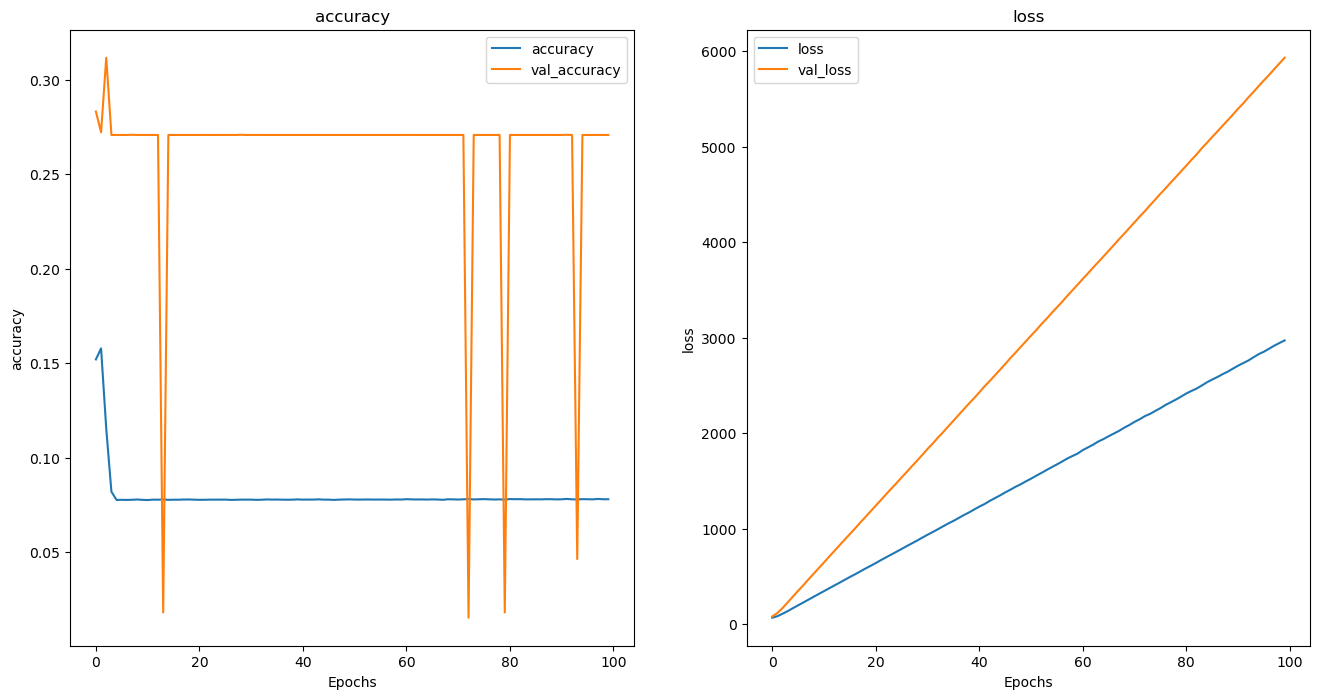

In [33]:
#2
grid_search_language(params)

50002 8 tanh 0.5 0.0001 1
Epoch 1/30
260902/260902 [==============================] - 7381s 28ms/step - loss: 83.5396 - accuracy: 0.0785 - val_loss: 122.7956 - val_accuracy: 0.2708
Epoch 2/30
260902/260902 [==============================] - 7392s 28ms/step - loss: 115.2510 - accuracy: 0.0776 - val_loss: 182.5611 - val_accuracy: 0.0463
Epoch 3/30
260902/260902 [==============================] - 7300s 28ms/step - loss: 145.5213 - accuracy: 0.0777 - val_loss: 243.1018 - val_accuracy: 0.0463
Epoch 4/30
260902/260902 [==============================] - 7316s 28ms/step - loss: 175.4648 - accuracy: 0.0776 - val_loss: 303.8984 - val_accuracy: 0.2708
Epoch 5/30
260902/260902 [==============================] - 7278s 28ms/step - loss: 205.2393 - accuracy: 0.0777 - val_loss: 361.7731 - val_accuracy: 0.2708
Epoch 6/30
260902/260902 [==============================] - 7233s 28ms/step - loss: 235.2778 - accuracy: 0.0777 - val_loss: 422.4326 - val_accuracy: 0.2708
Epoch 7/30
260902/260902 [=============

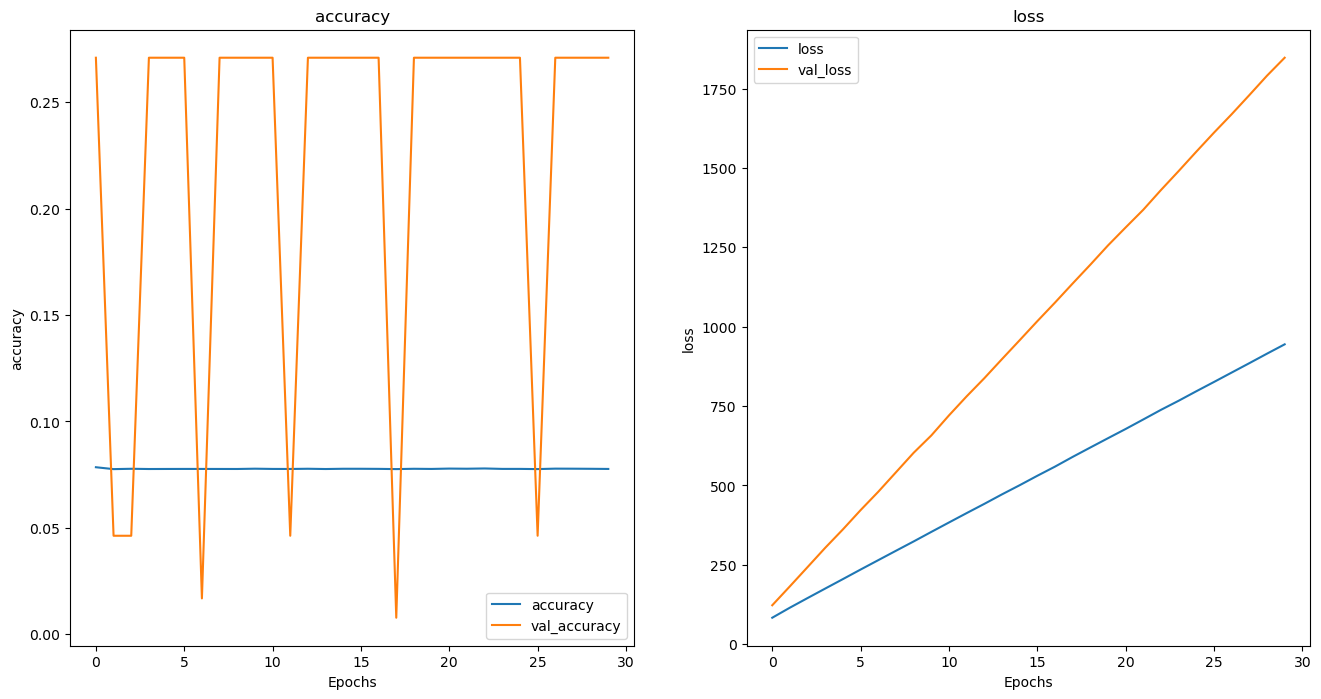

In [35]:
grid_search_language(params)

In [32]:
#batch size 32, 100 epocas antes, ahora 30, heuristic_pct_padding=.95 256 4-28-24 con el que estoy probando todo lo anterior, para probar una x una // para solucionar el error con menos epocas

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
history = model.fit(X, y, epochs=1, batch_size=32, validation_split=0.25, callbacks = [EarlyStopping(verbose = 1, patience = 10, restore_best_weights = True)])

260902/260902 [==============================] - 17071s 65ms/step - loss: 5.1213 - accuracy: 0.3419 - val_loss: 4.7843 - val_accuracy: 0.3827


In [20]:
#batch size 32, 100 epocas antes, ahora 30, heuristic_pct_padding=.95 256 4-28-24 con el que estoy probando todo lo anterior, para probar una x una // para solucionar el error con menos epocas
#prueba

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
history = model.fit(X, y, epochs=1, batch_size=32, validation_split=0.25, callbacks = [EarlyStopping(verbose = 1, patience = 10, restore_best_weights = True)])

NameError: name 'model' is not defined

In [33]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

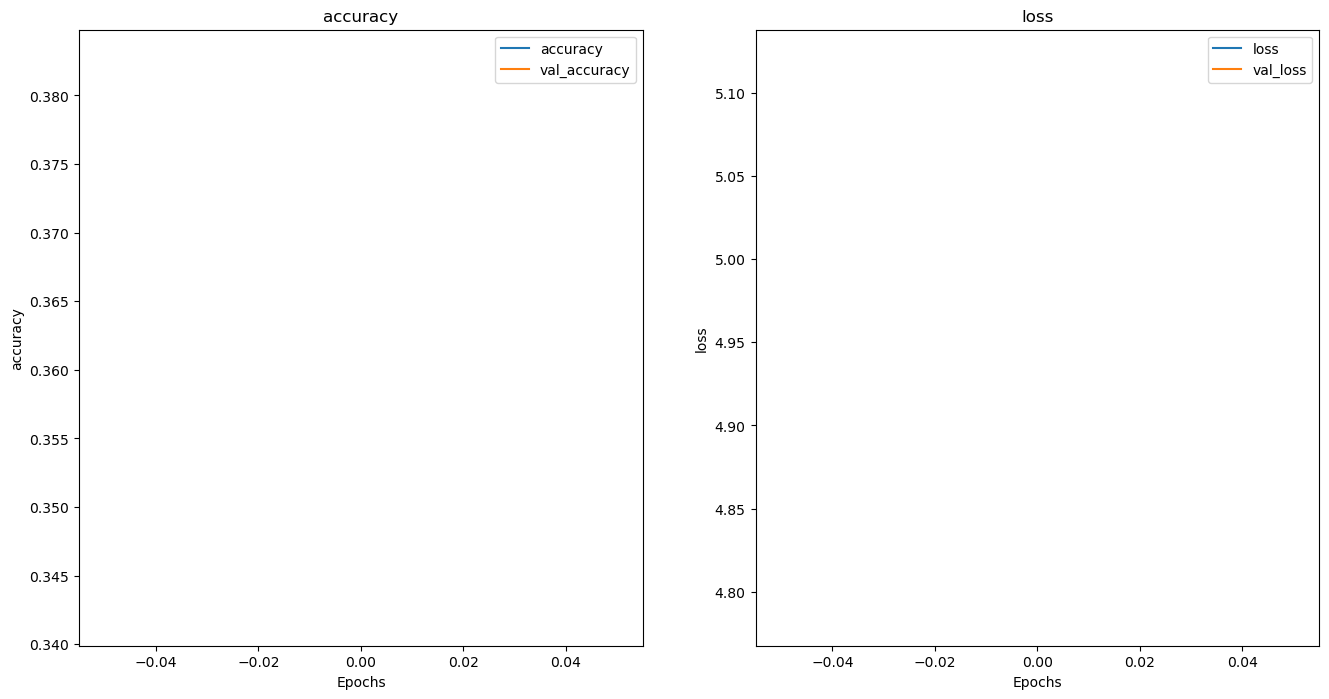

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [37]:
#batch size 32, 100 epocas antes, ahora 30, heuristic_pct_padding=.95 256 4-28-24 con el que estoy probando todo lo anterior, para probar una x una

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
history = model.fit(X, y, epochs=30, batch_size=32, validation_split=0.25, callbacks = [EarlyStopping(verbose = 1, patience = 10, restore_best_weights = True)])

Epoch 1/30
260902/260902 [==============================] - 16694s 64ms/step - loss: 4.7081 - accuracy: 0.3709 - val_loss: 4.4958 - val_accuracy: 0.4033
Epoch 2/30
260902/260902 [==============================] - 16927s 65ms/step - loss: 4.2498 - accuracy: 0.4151 - val_loss: 4.4368 - val_accuracy: 0.4150
Epoch 3/30
260902/260902 [==============================] - 16835s 65ms/step - loss: 4.0457 - accuracy: 0.4376 - val_loss: 4.3916 - val_accuracy: 0.4186
Epoch 4/30
260902/260902 [==============================] - 16893s 65ms/step - loss: 3.9030 - accuracy: 0.4545 - val_loss: 4.3775 - val_accuracy: 0.4203
Epoch 5/30
260902/260902 [==============================] - 16744s 64ms/step - loss: 3.6415 - accuracy: 0.4889 - val_loss: 4.3937 - val_accuracy: 0.4197
Epoch 8/30
260902/260902 [==============================] - 16783s 64ms/step - loss: 3.5831 - accuracy: 0.4973 - val_loss: 4.4032 - val_accuracy: 0.4183
Epoch 9/30
260902/260902 [==============================] - 16675s 64ms/step - los

In [38]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

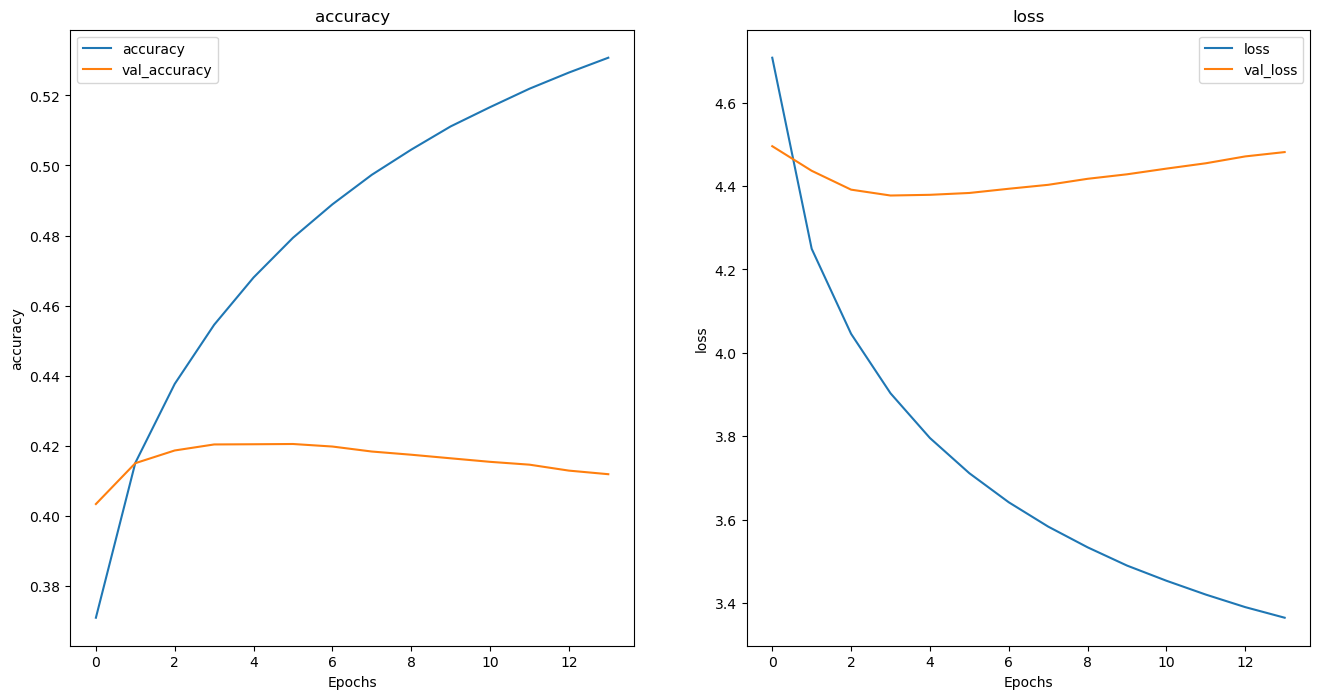

In [39]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [64]:
#batch size 32, 100 epocas, heuristic_pct_padding=1 256 14-12-23 probando para que no de overfitting

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.25, callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/100
11840/11840 [==============================] - 499s 42ms/step - loss: 6.6081 - accuracy: 0.1119 - val_loss: 6.2399 - val_accuracy: 0.1428
Epoch 2/100
  457/11840 [>.............................] - ETA: 7:34 - loss: 6.0244 - accuracy: 0.1591

KeyboardInterrupt: 

In [32]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

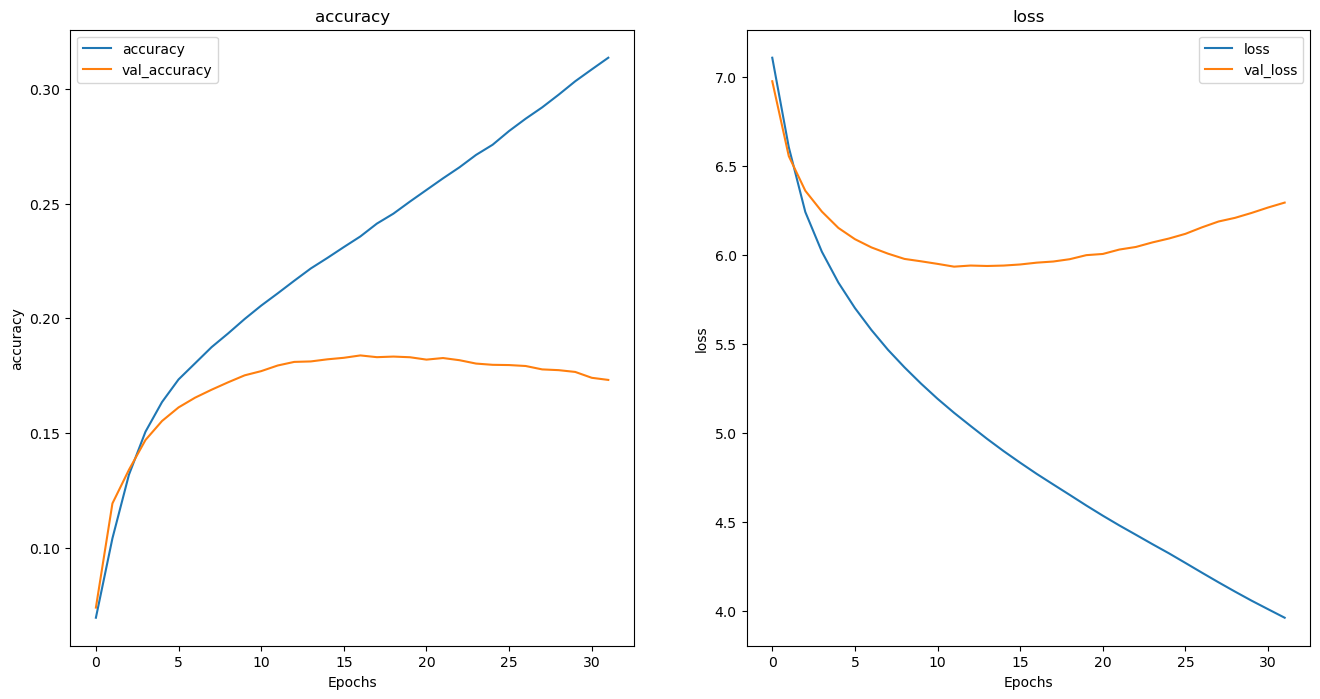

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [31]:
#batch size 32, 100 epocas, heuristic_pct_padding=1 256 14-12-23 probando para que no de overfitting, segunda prueba

model.compile(loss='sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics=['accuracy'])
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.25, callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/100
11959/11959 [==============================] - 536s 45ms/step - loss: 10.4113 - accuracy: 0.0556 - val_loss: 6.9031 - val_accuracy: 0.0842
Epoch 2/100
11959/11959 [==============================] - 532s 44ms/step - loss: 10.0514 - accuracy: 0.0808 - val_loss: 6.5744 - val_accuracy: 0.1202
Epoch 3/100
11959/11959 [==============================] - 532s 44ms/step - loss: 9.8376 - accuracy: 0.0980 - val_loss: 6.4867 - val_accuracy: 0.1361
Epoch 4/100
11959/11959 [==============================] - 531s 44ms/step - loss: 9.6843 - accuracy: 0.1086 - val_loss: 6.4324 - val_accuracy: 0.1471
Epoch 5/100
11959/11959 [==============================] - 524s 44ms/step - loss: 9.5772 - accuracy: 0.1172 - val_loss: 6.3489 - val_accuracy: 0.1546
Epoch 6/100
11959/11959 [==============================] - 527s 44ms/step - loss: 9.4919 - accuracy: 0.1236 - val_loss: 6.3180 - val_accuracy: 0.1602
Epoch 7/100
11959/11959 [==============================] - 527s 44ms/step - loss: 9.4239 - accurac

In [32]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

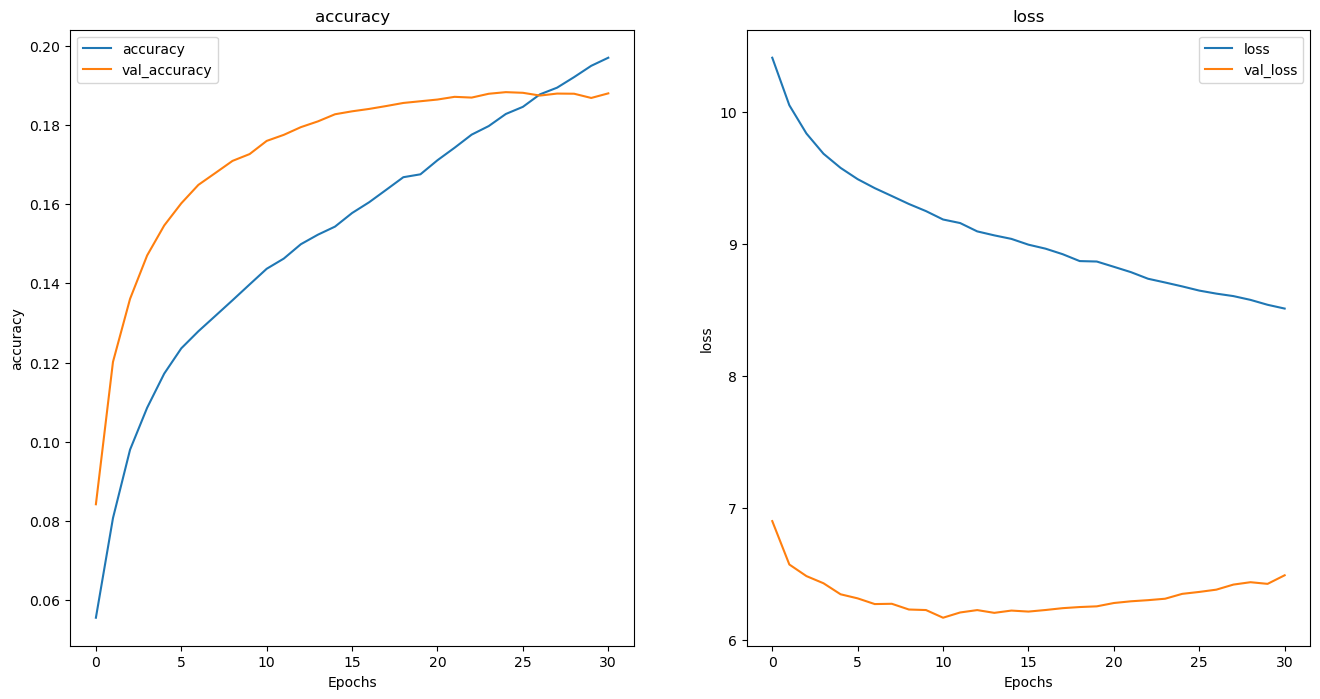

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Load the cached model.  **Warning:** we can only use the cached model if the original `target_docs` variable was subset to the first 200k rows.  I will explain this more in the tutorial.

In [78]:
# This will load the cached model

#assert len(target_docs) == 200000, 'target_docs should be truncated to the first 200k rows to use the cached model.'

fname = get_file(fname='kdd_lm_v2.h5', origin='https://storage.googleapis.com/kdd-seq2seq-2018/kdd_lm_v2.h5', )
model = load_model(fname)

In [18]:
print(len(target_docs))

1



There are a plethora of general purpose pre-trained models that will generate high-quality embeddings of phrases (also called sentence embeddings). [This article](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a) provides a great overview of the landscape. For example, Google’s universal sentence encoder works very well for many use cases and is available on [Tensorflow Hub](https://www.tensorflow.org/hub/modules/google/universal-sentence-encoder/1).

Despite the convenience of these pre-trained models, it can be advantageous to train a model that captures the domain-specific vocabulary and semantics of docstrings. There are many techniques one can use to create sentence embeddings. These range from simple approaches, like averaging word vectors to more sophisticated techniques like those used in the construction of the universal sentence encoder.

For this tutorial, we will leverage a the language model we trained earlier to generate embeddings for sentences.  It is important to carefully consider the corpus you use for training when building a language model. Ideally, you want to use a corpus that is of a similar domain to your downstream problem so you can adequately capture the relevant semantics and vocabulary. For example, a great corpus for this problem would be stack overflow data, since that is a forum that contains an extremely rich discussion of code. However, in order to keep this tutorial simple, we re-use the set of docstrings as our corpus. This is sub-optimal as discussions on stack overflow often contain richer semantic information than what is in a one-line docstring. We leave it as an exercise for the reader to examine the impact on the final outcome by using an alternate corpus.

After we train the language model, our next task is to use this model to generate an embedding for each sentence. A common way of doing this is to summarize the hidden states of the language model.   A simple approach is to use aggregate stastics like the mean, max, or the sum of all the hidden states. There are other approaches that are outside the scope of this tutorial, and will discuss if time permits.

The below code extracts the hidden states from the encoder when given an input. There is one hidden state for each word in the sentence.

In [37]:
#antes -3 ahora -5 porque se agregaron más capas al modelo
embedding_model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

We can extract values from intermediate layers of this language model, and use those as sentence embeddings.  Here is how you can do that concretely with the language model we trained:

In [38]:
#ejemplo
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('input sequence: ', input_sequence, '\n\nhidden states:\n')
vec = proc.transform([input_sequence])[:,1:]
embedding_model.predict(vec)

input sequence:  While hostilities between the two Korean states and their allies tended to cease after the Armistice of 1953, the Korean War/Fatherland Liberation War continues to rage on paper and its effects whilst not often deadly, have led to the all too painful development of a divided and mutually hostile Korean peninsula. Today, the realities which many felt were set in stone after 1953 are rapidly changing. The so-called “demilitarised zone” separating a politically divided Korea is now home to joint patrols where soldiers from both sides interact with one another whilst embracing a spirit of peace and fraternity.

Today, rather than mining the border or building ramparts, the South Korea government has begun the building of a new railway link that will allow both Korean states to at long last have a direct connection to one another. For Koreans themselves, the peace process is already considered largely irreversible. Although both sides are aware of various external pressures

array([[[-0.98195356, -0.44122383, -0.5357721 , ...,  0.3073376 ,
          0.06220651,  0.49919626],
        [-0.9467597 , -0.27550176,  0.9356745 , ...,  0.5807333 ,
          0.3058442 ,  0.79647624],
        [ 0.15863396,  0.2645303 ,  0.991887  , ...,  0.2116397 ,
          0.5892885 ,  0.8203891 ],
        ...,
        [ 0.50701153,  0.7549954 , -0.9953552 , ...,  0.9490226 ,
         -0.98202646,  0.8858462 ],
        [-0.94114053, -0.14330229, -0.9623925 , ...,  0.6241042 ,
         -0.5742662 ,  0.02205698],
        [-0.96015567,  0.05267348, -0.99912417, ...,  0.50633824,
         -0.93325454,  0.4762662 ]]], dtype=float32)

Let's extract the hidden states for all the sentences in our training data.

In [39]:
test_vecs = proc.transform(test_docs)

In [40]:
test_vecs.shape

(79256, 190)

In [41]:
hidden_states = embedding_model.predict(test_vecs[:, 1:])

In [42]:
print(hidden_states.shape)

(79256, 189, 32)


In [44]:
#original
print(hidden_states.shape)

(4195, 109, 256)


As mentioned earlier, we can compute aggregate statistics over the hidden states.  This is how you can do that:

In [45]:
#Cálculo de Vectores Promedio, Máximo y Suma
#Podemos calcular estadísticas agregadas sobre los estados ocultos. Así:
mean_vecs = np.mean(hidden_states, axis=1)
max_vecs = np.max(hidden_states, axis=1)
sum_vecs = np.sum(hidden_states, axis=1)

In [46]:
print(sum_vecs)

[[  5.681855   19.805836   15.325082  ...   7.255291    9.398727
   36.223583 ]
 [ -7.376855    6.468033   18.050964  ... -10.627568  -23.886862
   33.324543 ]
 [  9.706526    6.2559404 -41.632603  ...   3.796231  -28.334383
   39.98068  ]
 ...
 [-16.55443    16.422197   58.21908   ...  -8.742866  -13.248982
   26.172571 ]
 [-23.489754  -11.3177395 -31.863316  ...  -7.5782495 -47.919254
   36.84445  ]
 [-13.724818    3.9195006 -29.988567  ...  -1.65807   -30.903244
   45.718536 ]]


In [47]:
print(sum_vecs.shape)

(4195, 256)


In [48]:
print(sum_vecs)

[[  5.681855   19.805836   15.325082  ...   7.255291    9.398727
   36.223583 ]
 [ -7.376855    6.468033   18.050964  ... -10.627568  -23.886862
   33.324543 ]
 [  9.706526    6.2559404 -41.632603  ...   3.796231  -28.334383
   39.98068  ]
 ...
 [-16.55443    16.422197   58.21908   ...  -8.742866  -13.248982
   26.172571 ]
 [-23.489754  -11.3177395 -31.863316  ...  -7.5782495 -47.919254
   36.84445  ]
 [-13.724818    3.9195006 -29.988567  ...  -1.65807   -30.903244
   45.718536 ]]


In [62]:
print(sum_vecs.shape)

(4195, 256)


In [60]:
print(sum_vecs[0].shape)

(256,)


In [77]:
print(sum_vecs[0].shape)

()


In [49]:
dimension = hidden_states.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(sum_vecs):
    index.add_item(i, v)
index.build(10)

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

### Search nearest neighbors

In [50]:
#ejemplo usando lo anterior
input_sequence = test_docs[random.randint(0, len(test_docs))]
print('Query: ', input_sequence)

vec = proc.transform([input_sequence])[:,1:]
vec = np.sum(embedding_model.predict(vec), axis=1)
ids, _ = index.get_nns_by_vector(vec.T, 10, include_distances=True)

print('\nSearch Results:')
[test_docs[i] for i in ids][1:]

Query:  Jen Mouer, her husband, Daniel, and daughters Julia, left, and Nora, both 16. The Virginia family has been planning to use a home equity loan to pay a portion of the girls' college costs, and pay it off in full each year.

For parents facing the prospect of six-figure college bills, every bit of savings and every last tax break helps. So as Americans digested the details of the tax bill that passed last month, it was natural to lament the end of deductions for interest people pay on home equity loans. After all, if you don't have enough savings but have been paying down your mortgage, it's awfully tempting to borrow against your house to help pay for college. Many colleges know this and seem to count on it. In fact, scores of the more expensive private ones ask about home equity during the financial aid process and factor it into what they ask you to pay. The change in the tax bill raises two questions then, one immediate and one that is timeless. Will the colleges ask less of 

['The program that public servants can use to have their federal student loans forgiven is such a quagmire for borrowers that Congress had to set up a relief program for the relief program. So far, it\'s not performing much better. It has been nearly five months since the Department of Education released instructions for a $350 million pot of money that some public servants can use if they received bad information about the loan forgiveness program and ended up in the wrong type of repayment plan. Tens of thousands of people have applied for the relief program. But so far, most have been rejected, and as of late last month, none among the few thousand who remain in the running have seen their debt balances go to zero. In response to an inquiry led by Senator Tim Kaine, Democrat of Virginia, the department disclosed last week that 28,207 people had submitted requests as of Sept. 28 and that it had found 21,672 ineligible almost immediately. It then culled "approximately" half of the rem

# Modelo sequence-to-sequence

In [10]:
print('source (code input): ', source_docs[0])
print("")
print('target (description output): ', target_docs[0])

source (code input):  President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy.Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good.Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals.Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which t

## Preprocesamiento

In [6]:
source_proc = processor(heuristic_pct_padding=1, keep_n=50000)
source_vecs = source_proc.fit_transform(source_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [7]:
target_proc = processor(append_indicators=True, heuristic_pct_padding=1, keep_n=50000, padding ='post')
target_vecs = target_proc.fit_transform(target_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [8]:
encoder_input_data = source_vecs
encoder_seq_len = encoder_input_data.shape[1]

decoder_input_data = target_vecs[:, :-1]
decoder_target_data = target_vecs[:, 1:]

# num_encoder_tokens = max(source_proc.id2token.keys()) + 1
# num_decoder_tokens = max(target_proc.id2token.keys()) + 1
num_encoder_tokens = 41089
num_decoder_tokens = 24007

# print(source_vecs[1])
# print("--")
# print(source_docs[1])
print(num_encoder_tokens)
print(num_decoder_tokens)
print(encoder_seq_len)
print(decoder_input_data.shape[1])
print(decoder_target_data.shape[1])

41089
24007
900
189
189


## Modelo Codificador

In [48]:
#agrupado para hacer grid search
def encoder_arc(enc_dropout_var, enc_word_emb_dim_var):
    
 word_emb_dim=enc_word_emb_dim_var
 hidden_state_dim=1024
 encoder_seq_len=encoder_input_data.shape[1]
 num_encoder_tokens=max(source_proc.id2token.keys()) + 1
 num_decoder_tokens=max(target_proc.id2token.keys()) + 1

 encoder_inputs = Input(shape=(encoder_seq_len,), name='Encoder-Input')
 x = Embedding(num_encoder_tokens, word_emb_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
 x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
 print("encoder", enc_dropout_var)
 _, state_h = GRU(hidden_state_dim, return_state=True, name='Encoder-Last-GRU', dropout=enc_dropout_var)(x)
 encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
 seq2seq_encoder_out = encoder_model(encoder_inputs)

 return encoder_inputs, encoder_model, seq2seq_encoder_out



In [9]:
#para probar con un parametro a la vez
word_emb_dim=256
hidden_state_dim=1024
encoder_seq_len=encoder_seq_len
num_encoder_tokens=num_encoder_tokens
num_decoder_tokens=num_decoder_tokens

encoder_inputs = Input(shape=(encoder_seq_len,), name='Encoder-Input')
x = Embedding(num_encoder_tokens, word_emb_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)
_, state_h = GRU(hidden_state_dim, return_state=True, name='Encoder-Last-GRU', dropout=0.25)(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [10]:
encoder_model.summary()

Model: "Encoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   [(None, 900)]             0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 900, 256)          10518784  
_________________________________________________________________
Encoder-Batchnorm-1 (BatchNo (None, 900, 256)          1024      
_________________________________________________________________
Encoder-Last-GRU (GRU)       [(None, 1024), (None, 102 3938304   
Total params: 14,458,112
Trainable params: 14,457,600
Non-trainable params: 512
_________________________________________________________________


## Modelo Decodificador

In [49]:
#agrupado para gacer grid search
def decoder_arc(dec_dropout_var, dec_dense_var, dec_word_emb_dim_var, seq2seq_encoder_out):
    
 word_emb_dim = dec_word_emb_dim_var
 hidden_state_dim = 1024 
    
 decoder_inputs = Input(shape=(None,), name='Decoder-Input')
 dec_emb = Embedding(num_decoder_tokens, word_emb_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
 dec_emb_dropout = Dropout(dec_dropout_var, name ="Decoder-Embedding-Dropout")(dec_emb)
 dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb_dropout)
 decoder_gru = GRU(hidden_state_dim, return_state=True, return_sequences=True, name='Decoder-GRU', dropout=dec_dropout_var, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))                                  
 decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
 decoder_dense = Dense(dec_dense_var, activation='relu', name='Decoder-Dense')(decoder_gru_output)
 decoder_dropout = Dropout(dec_dropout_var, name='Decoder-Dropout')(decoder_dense)
 x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_dropout)
 decoder_outputs = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')(x)
 print("decoder", dec_dropout_var)
    
 return decoder_outputs, decoder_inputs



In [11]:
#regularizer en decoder_gru
decoder_inputs = Input(shape=(None,), name='Decoder-Input')
dec_emb = Embedding(num_decoder_tokens, word_emb_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_emb_dropout = Dropout(0.25, name ="Decoder-Embedding-Dropout")(dec_emb)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb_dropout)
decoder_gru = GRU(hidden_state_dim, return_state=True, return_sequences=True, name='Decoder-GRU', dropout=0.25, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))                                  
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
decoder_dense = Dense(200, activation='relu', name='Decoder-Dense')(decoder_gru_output)
decoder_dropout = Dropout(0.25, name='Decoder-Dropout')(decoder_dense)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_dropout)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')(x)
#decoder_outputs = decoder_dense(x)

In [12]:
#sin regularizers en decoder_gru
decoder_inputs = Input(shape=(None,), name='Decoder-Input')
dec_emb = Embedding(num_decoder_tokens, word_emb_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)
decoder_gru = GRU(hidden_state_dim, return_state=True, return_sequences=True, name='Decoder-GRU', dropout=.25)
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
decoder_dense = Dense(200, activation='relu', name='Decoder-Dense')(decoder_gru_output)
decoder_dropout = Dropout(0.25, name='Decoder-Dropout')(decoder_dense)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_dropout)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')(x)
#decoder_outputs = decoder_dense(x)

## Modelo sequence-to-sequence

In [50]:
#cuando se agrupan
def define_seq2seq_model(dec_dropout_var, dec_dense_var, dec_word_emb_dim_var, enc_dropout_var, enc_word_emb_dim_var):
    encoder_inputs, encoder_model, seq2seq_encoder_out = encoder_arc(enc_dropout_var, enc_word_emb_dim_var)
    decoder_outputs, decoder_inputs = decoder_arc(dec_dropout_var, dec_dense_var, dec_word_emb_dim_var, seq2seq_encoder_out)
    
    return Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) #**

Summary of model architecture:

In [13]:
seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 256)    6145792     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Embedding-Dropout (Drop (None, None, 256)    0           Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      [(None, 900)]        0                                            
______________________________________________________________________________________________

## Entrenamiento y pruebas

In [53]:
#grid search
params = [
           [0.25, 200, 512, 0.25, 512, 0.0001],
           [0.25, 200, 256, 0.25, 256, 0.0001],
           [0.25, 200, 1024, 0.25, 1024, 0.0001],
           [0.25, 300, 256, 0.25, 256, 0.0001],
           [0.25, 300, 512, 0.25, 512, 0.0001],
           [0.25, 300, 1024, 0.25, 1024, 0.0001]
    
           #[],
           #[],
           #[]

    
    
         ]

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def grid_search(params):
    for param in params:
        print(param[0], param[1], param[2], param[3], param[4], param[5])
        dec_dropout_var, dec_dense_var, dec_word_emb_dim_var, enc_dropout_var, enc_word_emb_dim_var = param[0], param[1], param[2], param[3], param[4]
        learning_rate = param[5]
        seq2seq_model = define_seq2seq_model(dec_dropout_var, dec_dense_var, dec_word_emb_dim_var, enc_dropout_var, enc_word_emb_dim_var)
        seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = param[5]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=32,
                            epochs=300,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])
        
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plot_graphs(history, 'accuracy')

        plt.subplot(1, 2, 2)
        plot_graphs(history, 'loss')
        
        print("--------------------")
        print("dec_dropout_var: ", dec_dropout_var, "dec_dense_var: ", dec_dense_var, dec_word_emb_dim_var, "dec_word_emb_dim_var", "enc_dropout_var: ", enc_dropout_var, "enc_word_emb_dim_var: ", enc_word_emb_dim_var, "learning_reate: ", learning_rate) 
        print("min val_loss: ", min(history.history['val_loss']), "accuracy en min val_loss: ", history.history['val_accuracy'][np.argmin(history.history['val_loss'])])
        print("epochs: ", len(history.history['val_loss']))
        
        

0.25 200 512 0.25 512 0.0001
encoder 0.25
decoder 0.25
Epoch 1/300
172/172 [==============================] - 63s 342ms/step - loss: 8.8312 - accuracy: 0.6073 - val_loss: 9.9806 - val_accuracy: 0.6344
Epoch 2/300
172/172 [==============================] - 57s 334ms/step - loss: 6.1409 - accuracy: 0.6330 - val_loss: 9.1026 - val_accuracy: 0.6506
Epoch 3/300
172/172 [==============================] - 57s 333ms/step - loss: 3.9407 - accuracy: 0.6378 - val_loss: 6.7860 - val_accuracy: 0.6517
Epoch 4/300
172/172 [==============================] - 58s 336ms/step - loss: 3.1075 - accuracy: 0.6379 - val_loss: 3.8301 - val_accuracy: 0.6517
Epoch 5/300
172/172 [==============================] - 57s 335ms/step - loss: 2.8959 - accuracy: 0.6379 - val_loss: 2.8793 - val_accuracy: 0.6517
Epoch 6/300
172/172 [==============================] - 57s 334ms/step - loss: 2.8063 - accuracy: 0.6385 - val_loss: 2.7288 - val_accuracy: 0.6534
Epoch 7/300
172/172 [==============================] - 57s 334ms/step

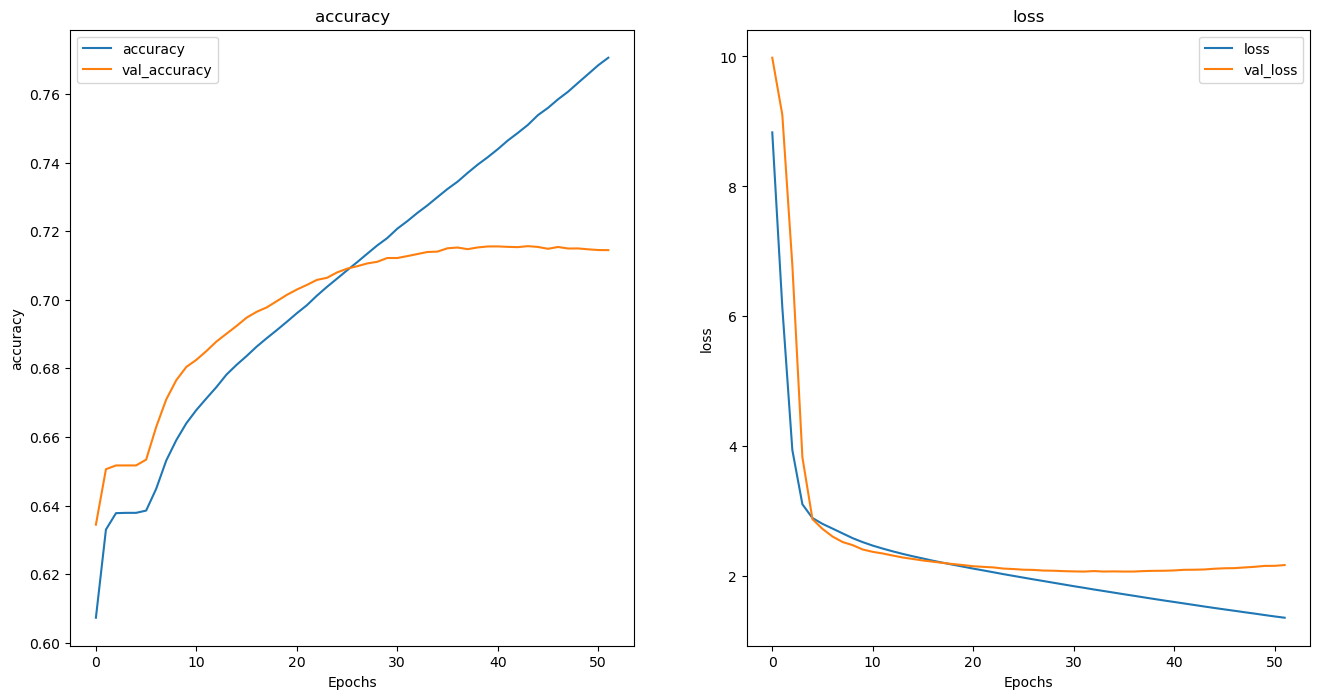

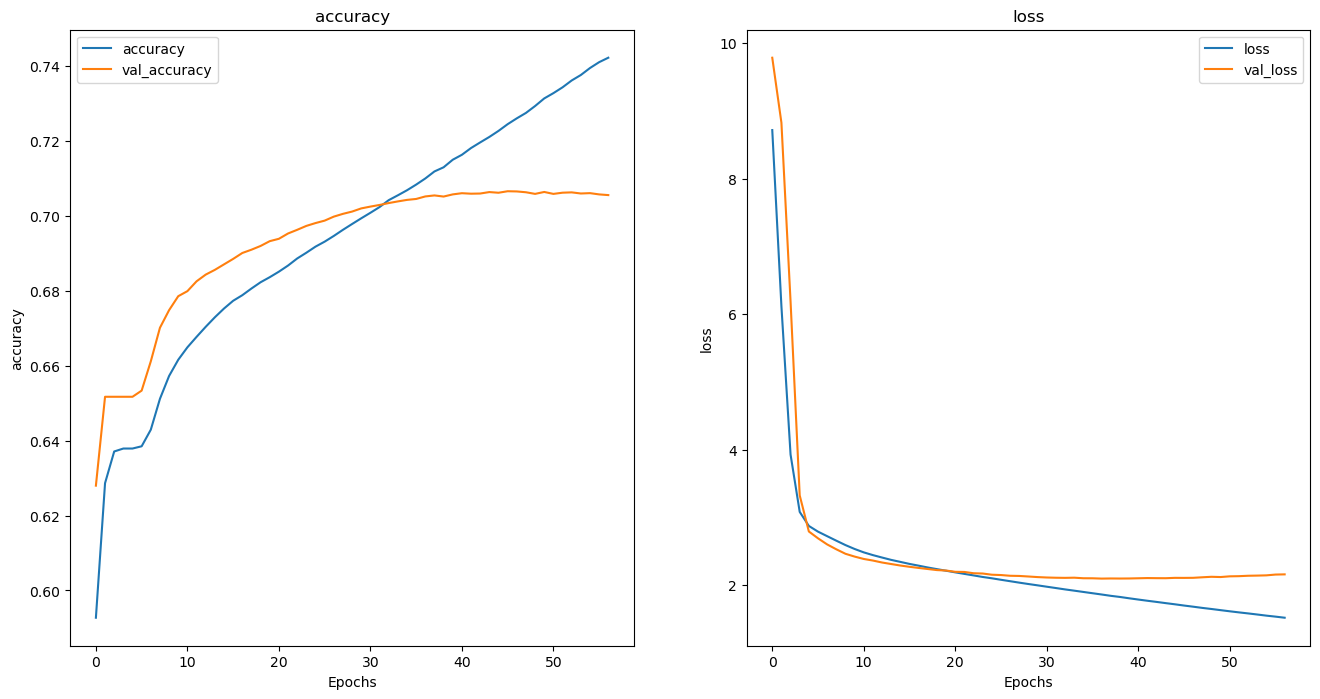

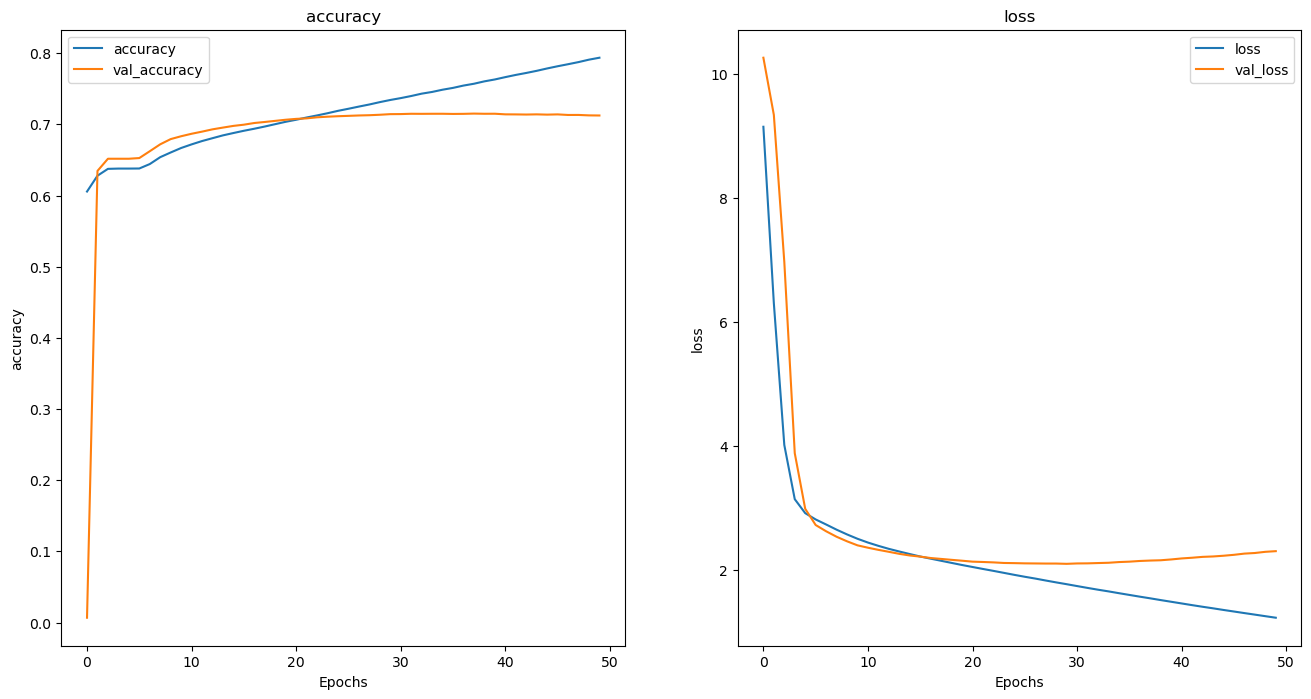

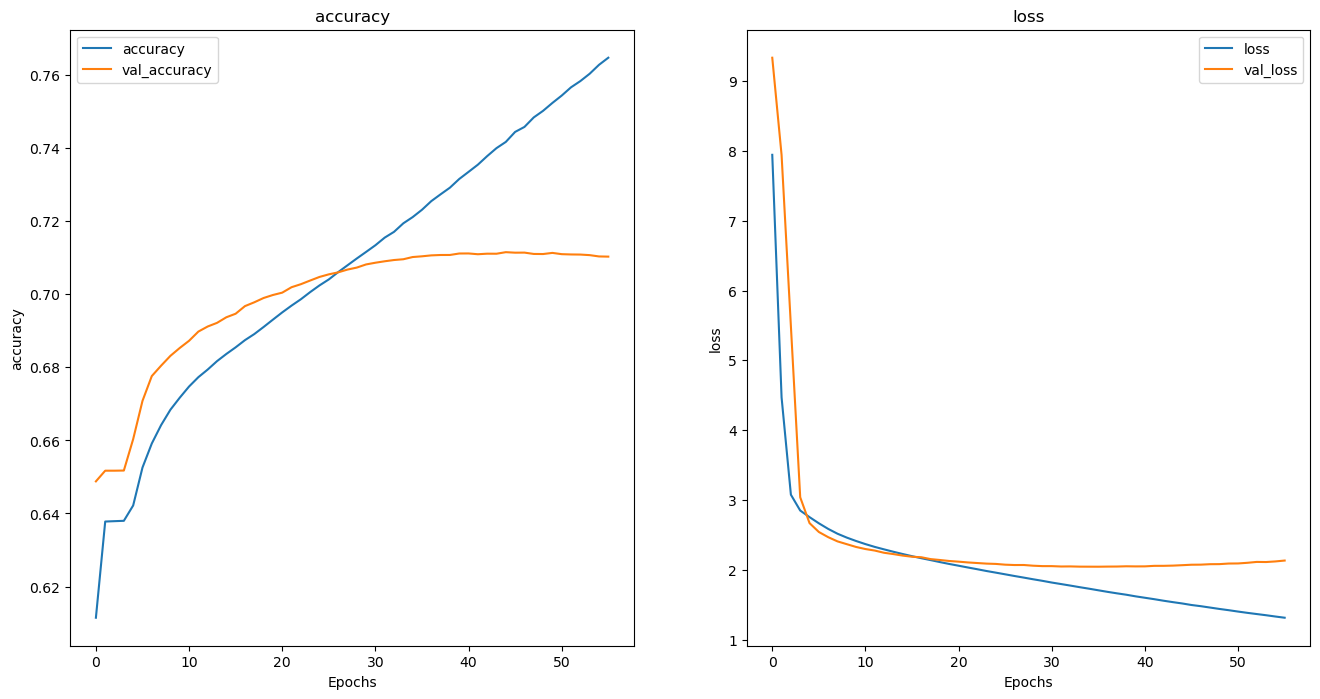

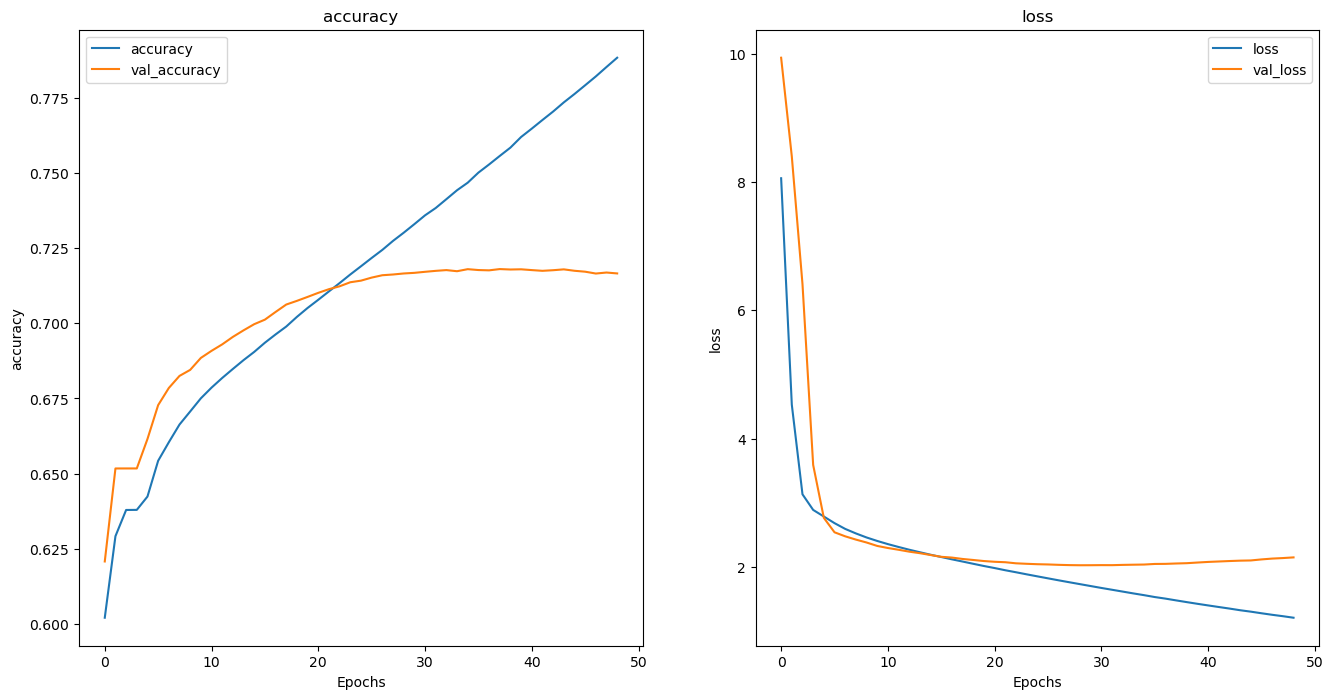

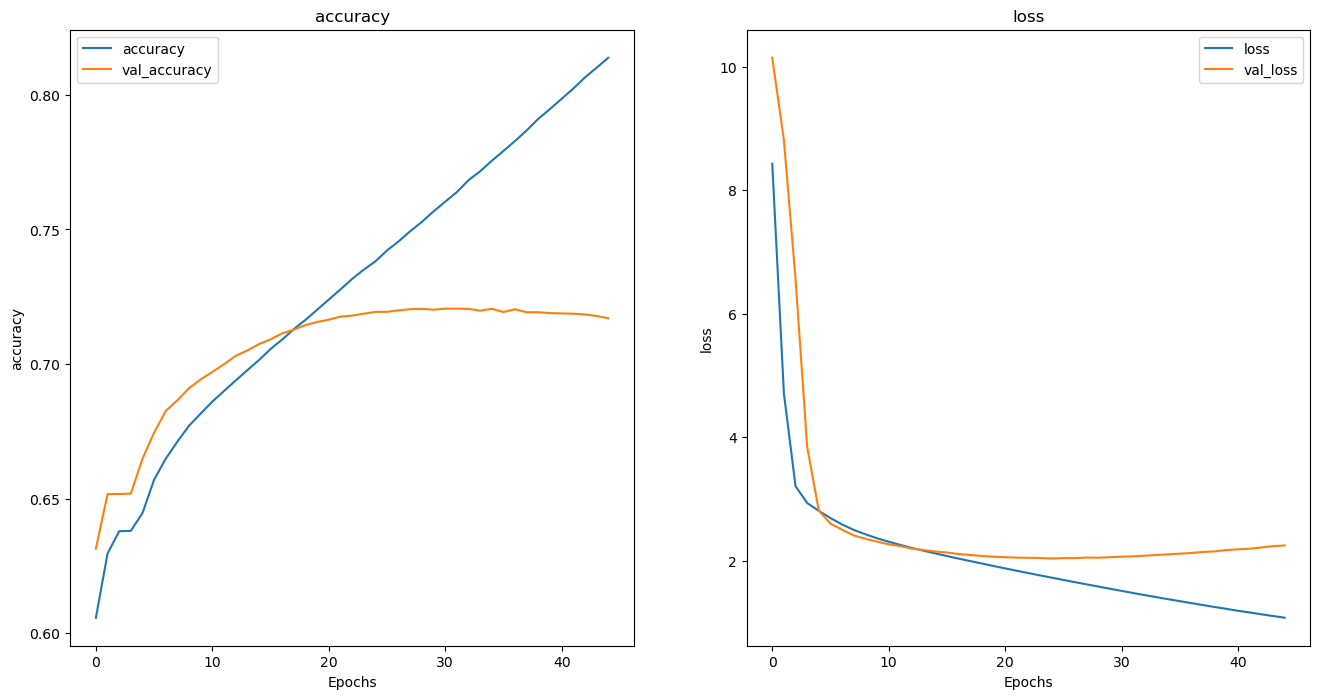

In [54]:
grid_search(params)

In [15]:
#prueba sin dropout 0.25-300-512-0.25-512-0.0001
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 59s 323ms/step - loss: 8.1831 - accuracy: 0.6104 - val_loss: 9.9259 - val_accuracy: 0.6238
Epoch 2/200
172/172 [==============================] - 55s 320ms/step - loss: 4.6010 - accuracy: 0.6407 - val_loss: 8.6434 - val_accuracy: 0.6556
Epoch 3/200
172/172 [==============================] - 55s 320ms/step - loss: 3.1098 - accuracy: 0.6434 - val_loss: 6.4185 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 55s 320ms/step - loss: 2.8483 - accuracy: 0.6434 - val_loss: 3.6025 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 55s 321ms/step - loss: 2.7507 - accuracy: 0.6464 - val_loss: 2.7317 - val_accuracy: 0.6619
Epoch 6/200
172/172 [==============================] - 55s 321ms/step - loss: 2.6538 - accuracy: 0.6581 - val_loss: 2.5259 - val_accuracy: 0.6762
Epoch 7/200
172/172 [==============================] - 55s 321ms/step - loss: 2.5609 - accuracy: 0.6654 - val_loss: 2.4432 -

In [16]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

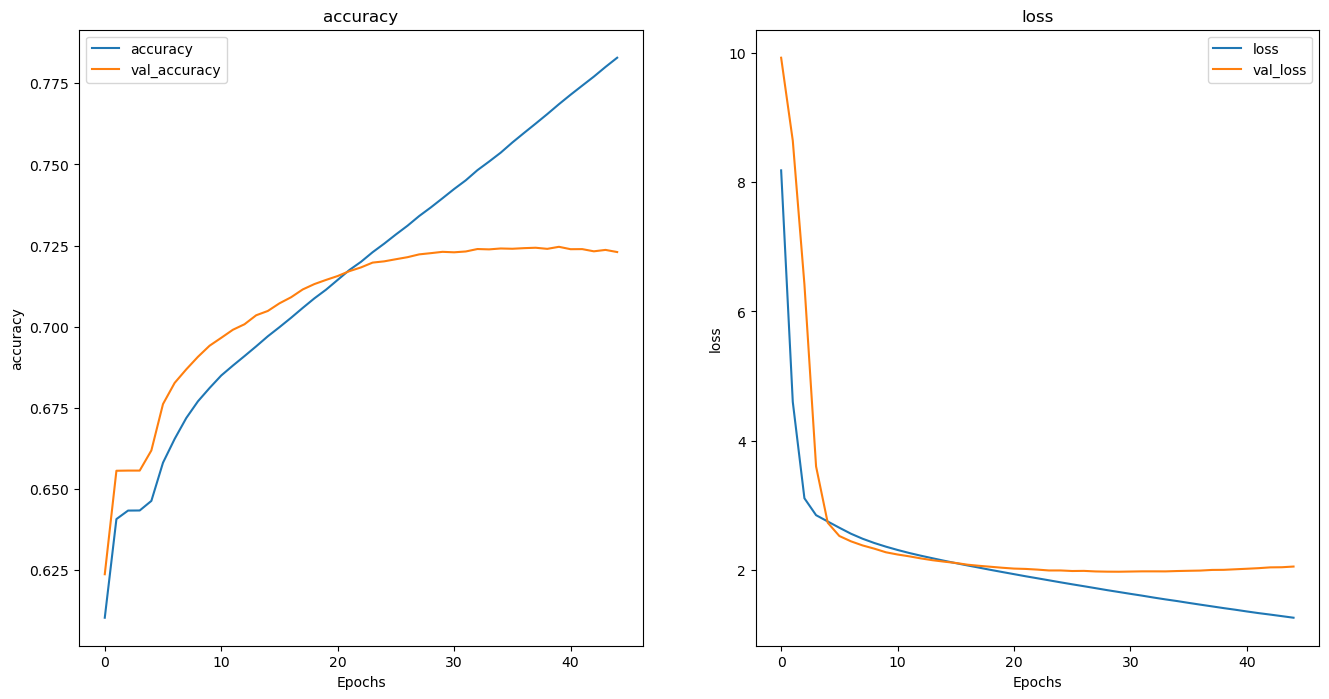

In [17]:
#prueba sin dropout 0.25-300-512-0.25-512-0.0001
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [15]:
#prueba sin dropout 0.25-200-256-0.25-256-0.01
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 50s 268ms/step - loss: 2.8488 - accuracy: 0.6477 - val_loss: 2.6258 - val_accuracy: 0.6643
Epoch 2/200
172/172 [==============================] - 46s 266ms/step - loss: 2.4228 - accuracy: 0.6657 - val_loss: 2.3541 - val_accuracy: 0.6764
Epoch 3/200
172/172 [==============================] - 46s 266ms/step - loss: 2.3273 - accuracy: 0.6729 - val_loss: 2.2420 - val_accuracy: 0.6874
Epoch 4/200
172/172 [==============================] - 46s 267ms/step - loss: 2.2583 - accuracy: 0.6770 - val_loss: 2.1979 - val_accuracy: 0.6913
Epoch 5/200
172/172 [==============================] - 46s 267ms/step - loss: 2.2111 - accuracy: 0.6796 - val_loss: 2.1812 - val_accuracy: 0.6929
Epoch 6/200
172/172 [==============================] - 46s 267ms/step - loss: 2.1691 - accuracy: 0.6820 - val_loss: 2.1569 - val_accuracy: 0.6945
Epoch 7/200
172/172 [==============================] - 46s 266ms/step - loss: 2.1314 - accuracy: 0.6841 - val_loss: 2.1432 -

In [16]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

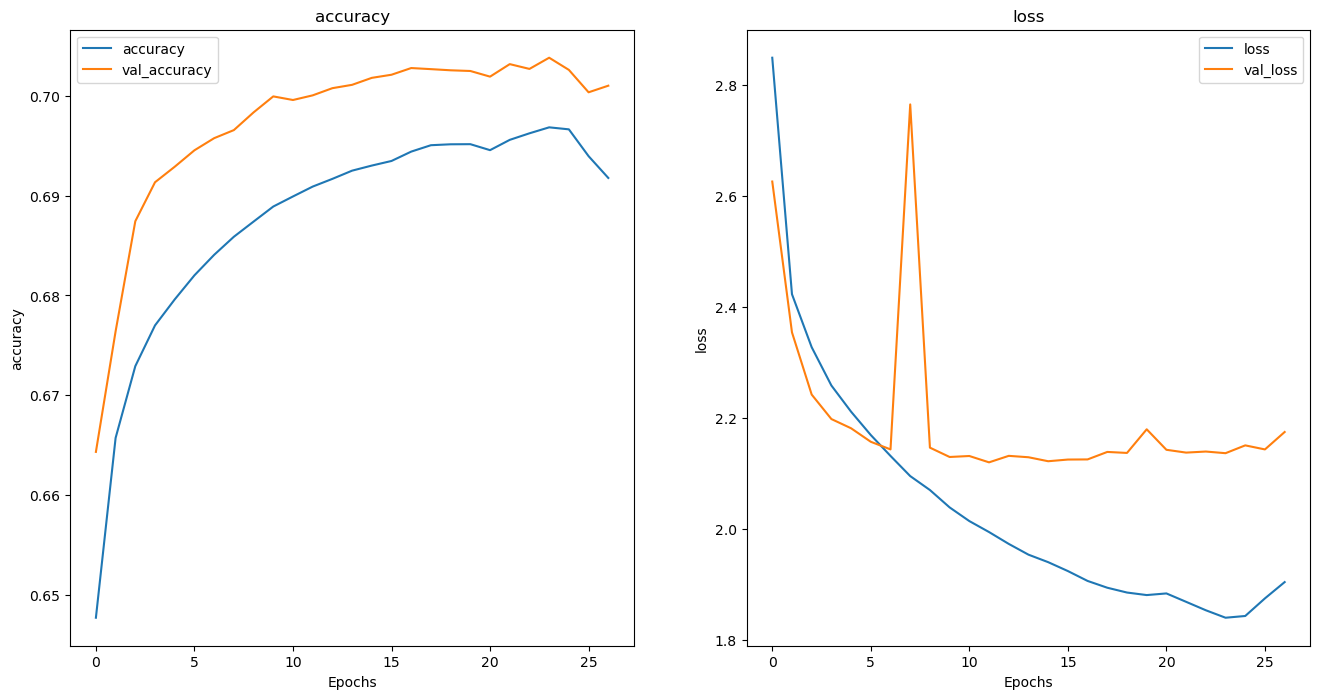

In [17]:
#prueba sin dropout 0.25-200-256-0.25-256-0.01
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [16]:
#prueba sin dropout 0.75-200-1024-0.75-1024-0.0001
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 75s 417ms/step - loss: 9.3017 - accuracy: 0.5772 - val_loss: 9.1689 - val_accuracy: 0.6028
Epoch 2/200
172/172 [==============================] - 71s 411ms/step - loss: 8.0308 - accuracy: 0.6313 - val_loss: 7.6729 - val_accuracy: 0.6042
Epoch 3/200
172/172 [==============================] - 71s 412ms/step - loss: 6.5718 - accuracy: 0.6345 - val_loss: 5.6635 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 71s 412ms/step - loss: 5.0042 - accuracy: 0.6378 - val_loss: 3.8422 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 71s 411ms/step - loss: 3.8458 - accuracy: 0.6407 - val_loss: 3.0604 - val_accuracy: 0.6557
Epoch 6/200
172/172 [==============================] - 71s 412ms/step - loss: 3.3009 - accuracy: 0.6426 - val_loss: 2.8123 - val_accuracy: 0.6557
Epoch 7/200
172/172 [==============================] - 71s 411ms/step - loss: 3.0505 - accuracy: 0.6431 - val_loss: 2.7093 -

In [17]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

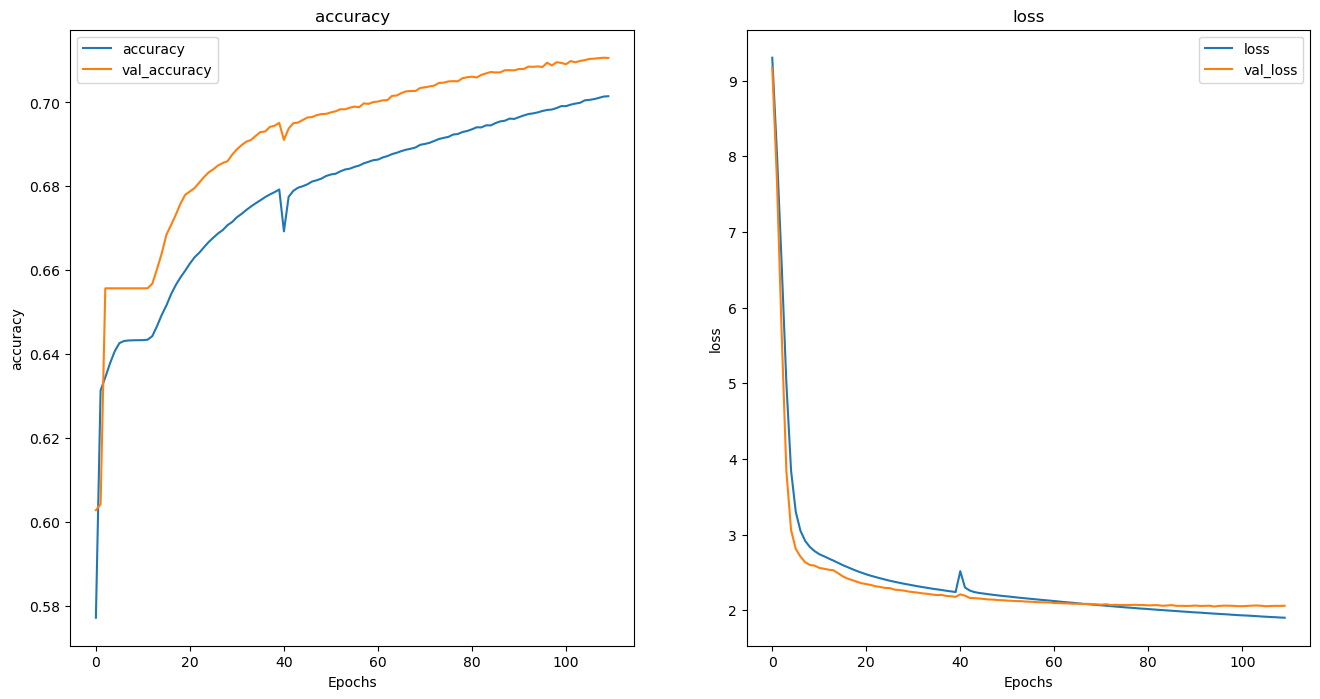

In [18]:
#prueba sin dropout 0.75-200-1024-0.75-1024-0.0001
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [14]:
#prueba sin dropout 0.75-200-256-0.75-256-0.01
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 49s 268ms/step - loss: 3.0742 - accuracy: 0.6368 - val_loss: 2.6258 - val_accuracy: 0.6557
Epoch 2/200
172/172 [==============================] - 46s 265ms/step - loss: 2.6073 - accuracy: 0.6482 - val_loss: 2.5276 - val_accuracy: 0.6629
Epoch 3/200
172/172 [==============================] - 46s 265ms/step - loss: 2.5335 - accuracy: 0.6539 - val_loss: 2.3794 - val_accuracy: 0.6724
Epoch 4/200
172/172 [==============================] - 46s 267ms/step - loss: 2.4811 - accuracy: 0.6581 - val_loss: 2.3272 - val_accuracy: 0.6772
Epoch 5/200
172/172 [==============================] - 46s 266ms/step - loss: 2.4476 - accuracy: 0.6612 - val_loss: 2.3077 - val_accuracy: 0.6802
Epoch 6/200
172/172 [==============================] - 46s 266ms/step - loss: 2.4217 - accuracy: 0.6627 - val_loss: 2.2914 - val_accuracy: 0.6824
Epoch 7/200
172/172 [==============================] - 46s 266ms/step - loss: 2.4000 - accuracy: 0.6641 - val_loss: 2.2666 -

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

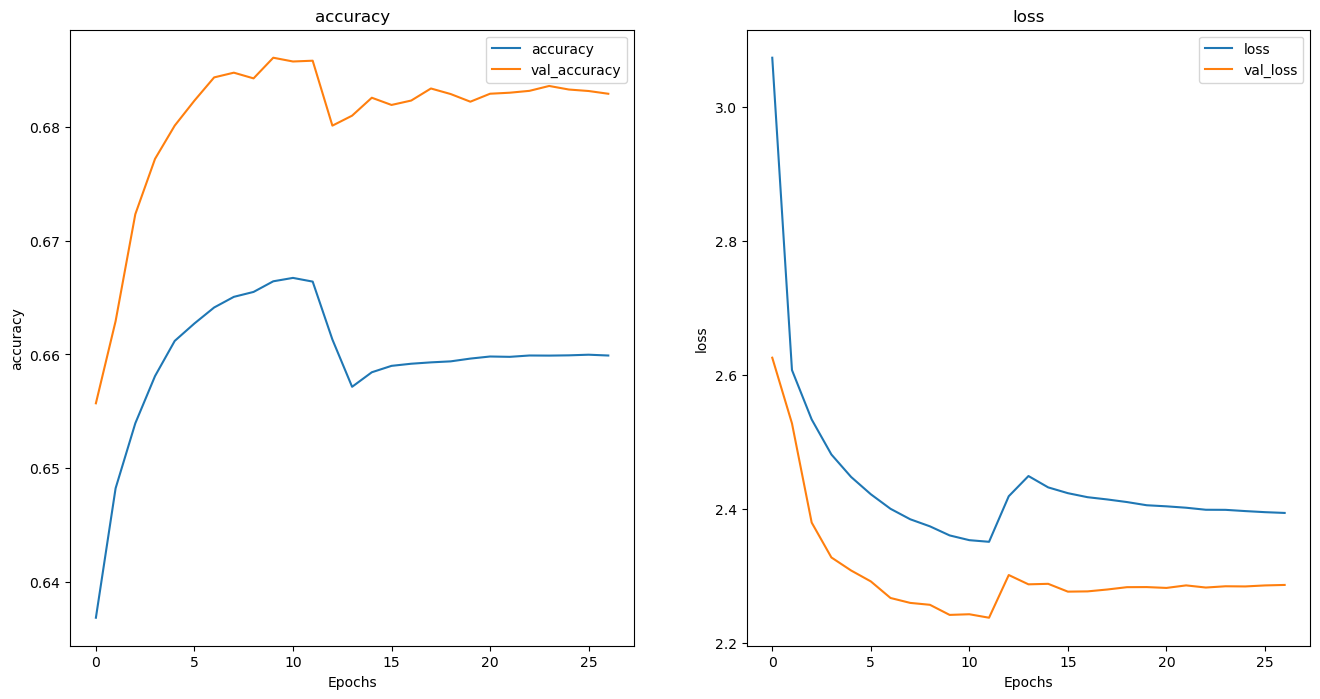

In [17]:
#prueba sin dropout 0.75-200-256-0.75-256-0.01
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [15]:
#prueba sin dropout 0.25-200-256-0.25-256-0-0001
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 50s 268ms/step - loss: 8.5453 - accuracy: 0.5998 - val_loss: 9.7804 - val_accuracy: 0.5594
Epoch 2/200
172/172 [==============================] - 46s 266ms/step - loss: 6.0997 - accuracy: 0.6260 - val_loss: 6.2768 - val_accuracy: 0.5753
Epoch 3/200
172/172 [==============================] - 46s 266ms/step - loss: 3.9087 - accuracy: 0.6390 - val_loss: 3.1139 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 46s 266ms/step - loss: 2.9968 - accuracy: 0.6434 - val_loss: 2.7136 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 46s 266ms/step - loss: 2.7800 - accuracy: 0.6434 - val_loss: 2.6612 - val_accuracy: 0.6557
Epoch 6/200
172/172 [==============================] - 46s 266ms/step - loss: 2.6798 - accuracy: 0.6474 - val_loss: 2.6477 - val_accuracy: 0.6653
Epoch 7/200
172/172 [==============================] - 46s 266ms/step - loss: 2.5982 - accuracy: 0.6570 - val_loss: 2.4912 -

In [17]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

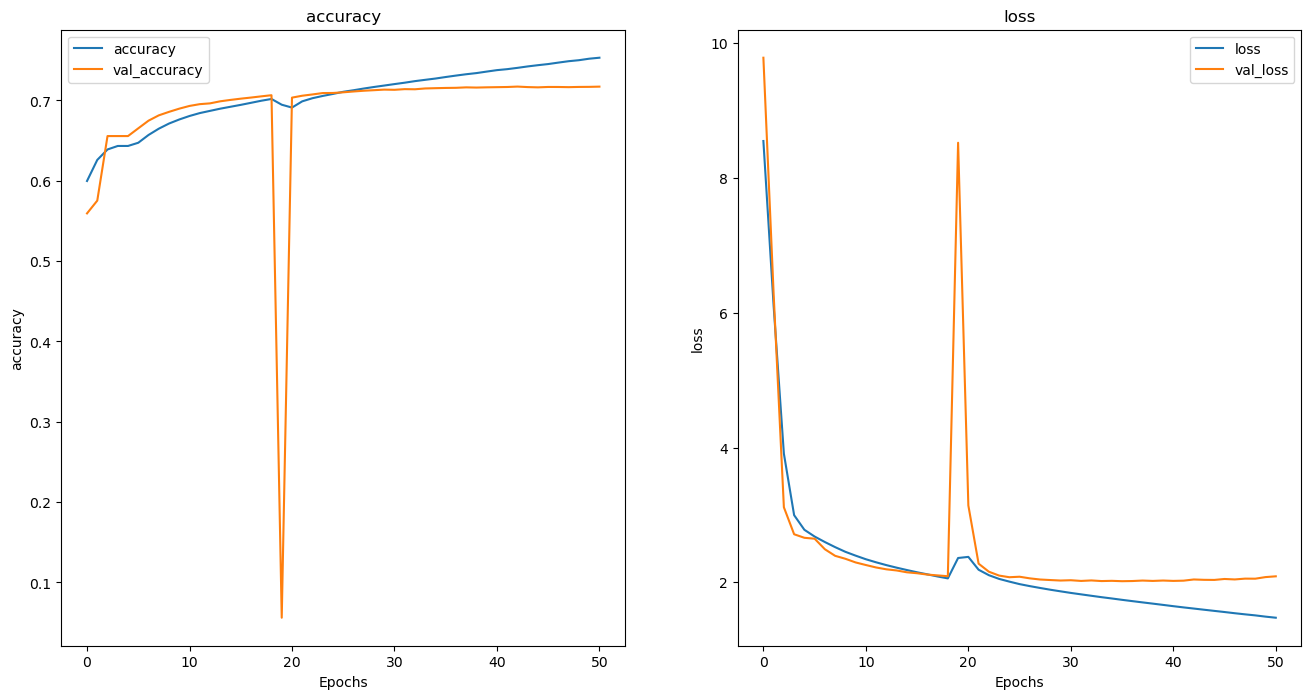

In [18]:
#prueba4
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [14]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.01

batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 50s 269ms/step - loss: 4.4720 - accuracy: 0.6368 - val_loss: 5.1073 - val_accuracy: 0.6553
Epoch 2/200
172/172 [==============================] - 46s 267ms/step - loss: 3.5735 - accuracy: 0.6616 - val_loss: 3.3745 - val_accuracy: 0.6780
Epoch 3/200
172/172 [==============================] - 46s 267ms/step - loss: 3.2752 - accuracy: 0.6716 - val_loss: 3.0533 - val_accuracy: 0.6888
Epoch 4/200
172/172 [==============================] - 46s 267ms/step - loss: 3.0782 - accuracy: 0.6777 - val_loss: 2.9345 - val_accuracy: 0.6939
Epoch 5/200
172/172 [==============================] - 46s 267ms/step - loss: 2.9330 - accuracy: 0.6822 - val_loss: 2.8502 - val_accuracy: 0.6974
Epoch 6/200
172/172 [==============================] - 46s 268ms/step - loss: 2.8146 - accuracy: 0.6857 - val_loss: 2.7827 - val_accuracy: 0.6996
Epoch 7/200
172/172 [==============================] - 46s 267ms/step - loss: 2.7142 - accuracy: 0.6887 - val_loss: 2.7492 -

In [15]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.01

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

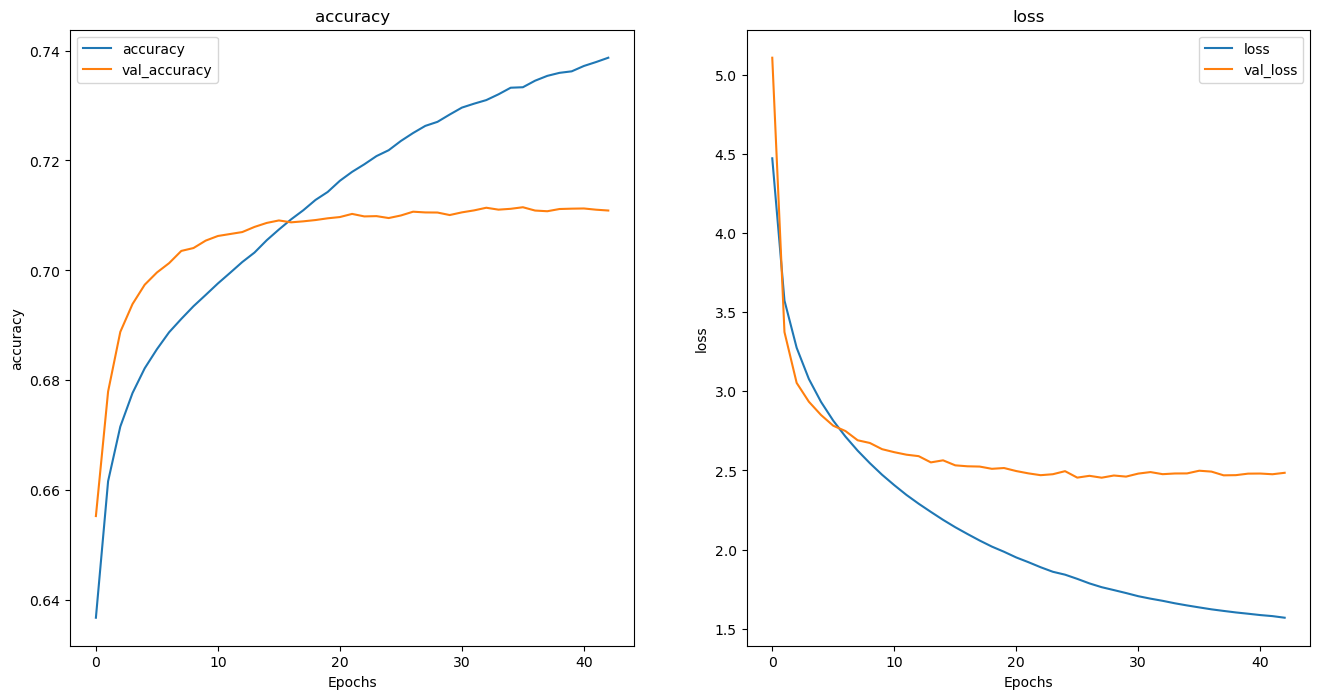

In [16]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.01
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [15]:
#prueba con regularizadores 0.75-300-256-0.75-256-0.0001

batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 51s 276ms/step - loss: 9.3484 - accuracy: 0.5397 - val_loss: 9.0150 - val_accuracy: 0.6331
Epoch 2/200
172/172 [==============================] - 47s 274ms/step - loss: 7.1810 - accuracy: 0.6314 - val_loss: 7.5211 - val_accuracy: 0.6343
Epoch 3/200
172/172 [==============================] - 47s 274ms/step - loss: 5.0507 - accuracy: 0.6388 - val_loss: 5.1645 - val_accuracy: 0.6380
Epoch 4/200
172/172 [==============================] - 47s 274ms/step - loss: 3.6728 - accuracy: 0.6421 - val_loss: 3.9327 - val_accuracy: 0.6471
Epoch 5/200
172/172 [==============================] - 47s 274ms/step - loss: 3.1720 - accuracy: 0.6430 - val_loss: 3.4571 - val_accuracy: 0.6498
Epoch 6/200
172/172 [==============================] - 47s 274ms/step - loss: 2.9805 - accuracy: 0.6432 - val_loss: 3.6427 - val_accuracy: 0.6449
Epoch 7/200
172/172 [==============================] - 47s 274ms/step - loss: 2.8842 - accuracy: 0.6432 - val_loss: 3.4301 -

In [16]:
#prueba con regularizadores 0.75-300-256-0.75-256-0.0001

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

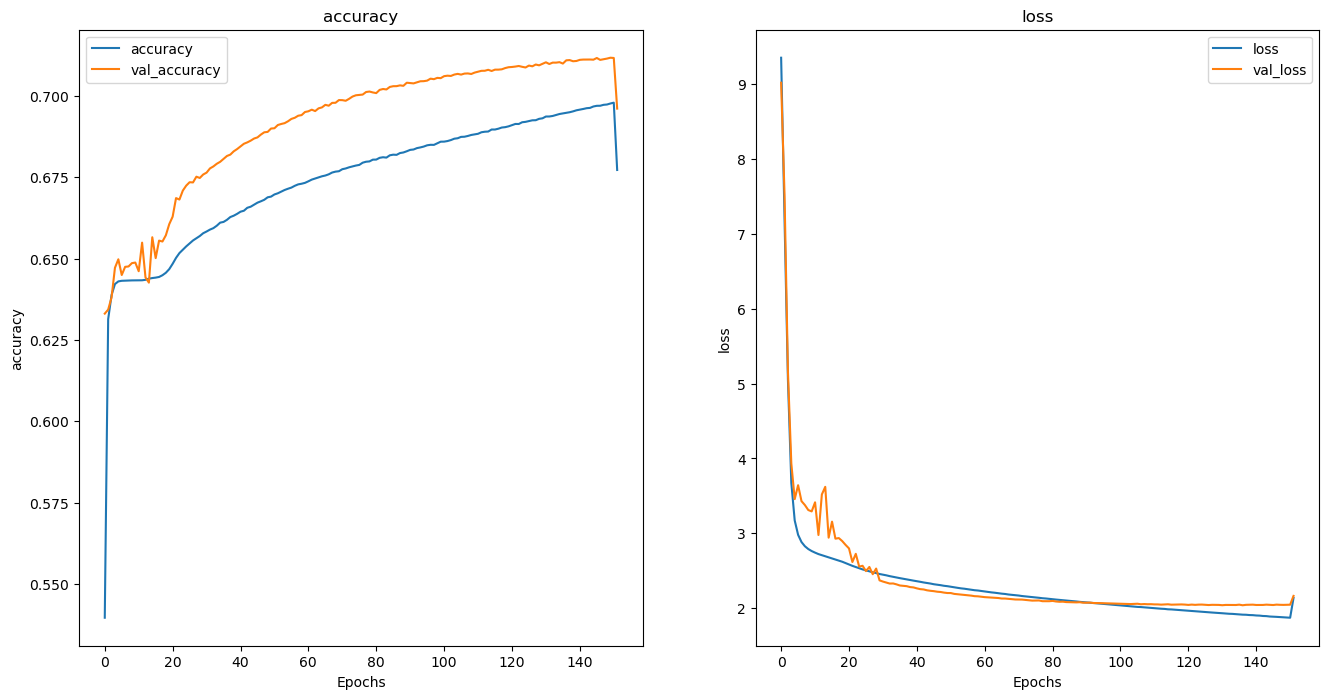

In [17]:
#prueba con regularizadores 0.75-300-256-0.75-256-0.0001
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [14]:
#prueba con regularizadores 0.25-300-512-0.25-512-0.0001

batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 59s 324ms/step - loss: 8.1777 - accuracy: 0.6171 - val_loss: 9.9095 - val_accuracy: 0.6356
Epoch 2/200
172/172 [==============================] - 55s 320ms/step - loss: 4.6014 - accuracy: 0.6430 - val_loss: 8.5641 - val_accuracy: 0.6556
Epoch 3/200
172/172 [==============================] - 55s 320ms/step - loss: 3.1038 - accuracy: 0.6434 - val_loss: 6.6019 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 55s 321ms/step - loss: 2.8455 - accuracy: 0.6434 - val_loss: 3.8343 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 55s 321ms/step - loss: 2.7433 - accuracy: 0.6472 - val_loss: 2.6567 - val_accuracy: 0.6650
Epoch 6/200
172/172 [==============================] - 55s 322ms/step - loss: 2.6417 - accuracy: 0.6592 - val_loss: 2.5132 - val_accuracy: 0.6764
Epoch 7/200
172/172 [==============================] - 55s 321ms/step - loss: 2.5507 - accuracy: 0.6662 - val_loss: 2.4406 -

In [15]:
#prueba con regularizadores 0.25-300-512-0.25-512-0.0001

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

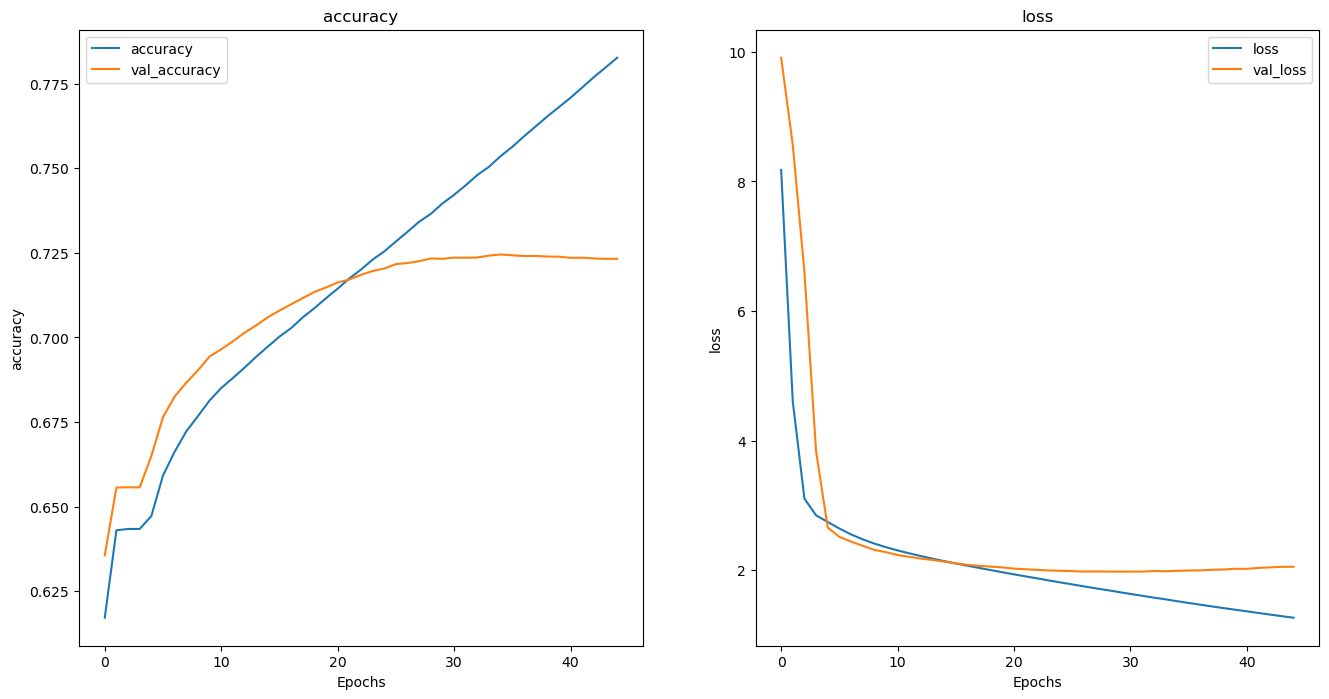

In [16]:
#prueba con regularizadores 0.25-300-512-0.25-512-0.0001
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [16]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.0001

batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 50s 270ms/step - loss: 8.7234 - accuracy: 0.6057 - val_loss: 9.7483 - val_accuracy: 0.6354
Epoch 2/200
172/172 [==============================] - 46s 266ms/step - loss: 6.1271 - accuracy: 0.6364 - val_loss: 8.7723 - val_accuracy: 0.6549
Epoch 3/200
172/172 [==============================] - 46s 267ms/step - loss: 3.9172 - accuracy: 0.6427 - val_loss: 6.4821 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 46s 267ms/step - loss: 3.0457 - accuracy: 0.6434 - val_loss: 3.5358 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 46s 268ms/step - loss: 2.8355 - accuracy: 0.6434 - val_loss: 2.8098 - val_accuracy: 0.6557
Epoch 6/200
172/172 [==============================] - 46s 268ms/step - loss: 2.7487 - accuracy: 0.6434 - val_loss: 2.6387 - val_accuracy: 0.6557
Epoch 7/200
172/172 [==============================] - 46s 267ms/step - loss: 2.6894 - accuracy: 0.6470 - val_loss: 2.5678 -

In [17]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.0002

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

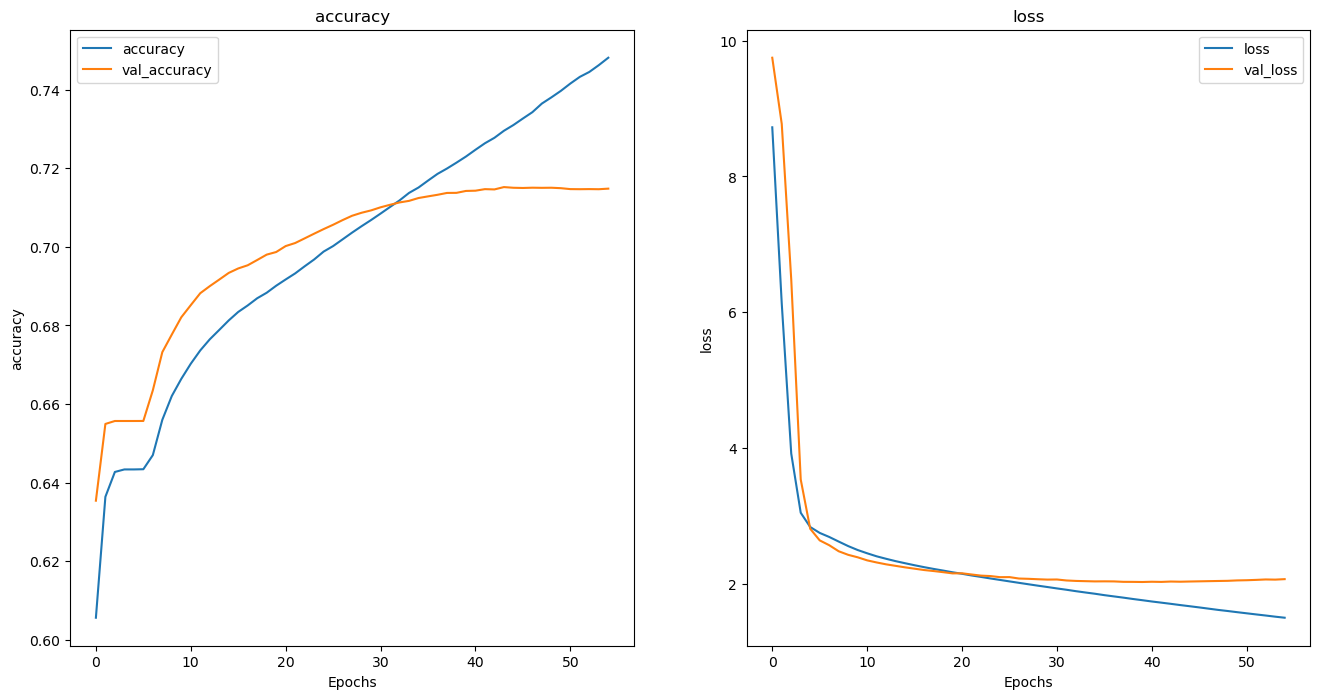

In [18]:
#prueba con regularizadores 0.25-200-256-0.25-256-0.0002
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [14]:
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 52s 276ms/step - loss: 8.0160 - accuracy: 0.6085 - val_loss: 9.4692 - val_accuracy: 0.6423
Epoch 2/200
172/172 [==============================] - 47s 273ms/step - loss: 4.5121 - accuracy: 0.6425 - val_loss: 8.1149 - val_accuracy: 0.6551
Epoch 3/200
172/172 [==============================] - 47s 273ms/step - loss: 3.0500 - accuracy: 0.6434 - val_loss: 5.7449 - val_accuracy: 0.6557
Epoch 4/200
172/172 [==============================] - 47s 275ms/step - loss: 2.8094 - accuracy: 0.6434 - val_loss: 3.1013 - val_accuracy: 0.6557
Epoch 5/200
172/172 [==============================] - 47s 275ms/step - loss: 2.7222 - accuracy: 0.6461 - val_loss: 2.6535 - val_accuracy: 0.6625
Epoch 6/200
172/172 [==============================] - 47s 275ms/step - loss: 2.6339 - accuracy: 0.6564 - val_loss: 2.4980 - val_accuracy: 0.6732
Epoch 7/200
172/172 [==============================] - 47s 274ms/step - loss: 2.5519 - accuracy: 0.6634 - val_loss: 2.4296 -

In [16]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

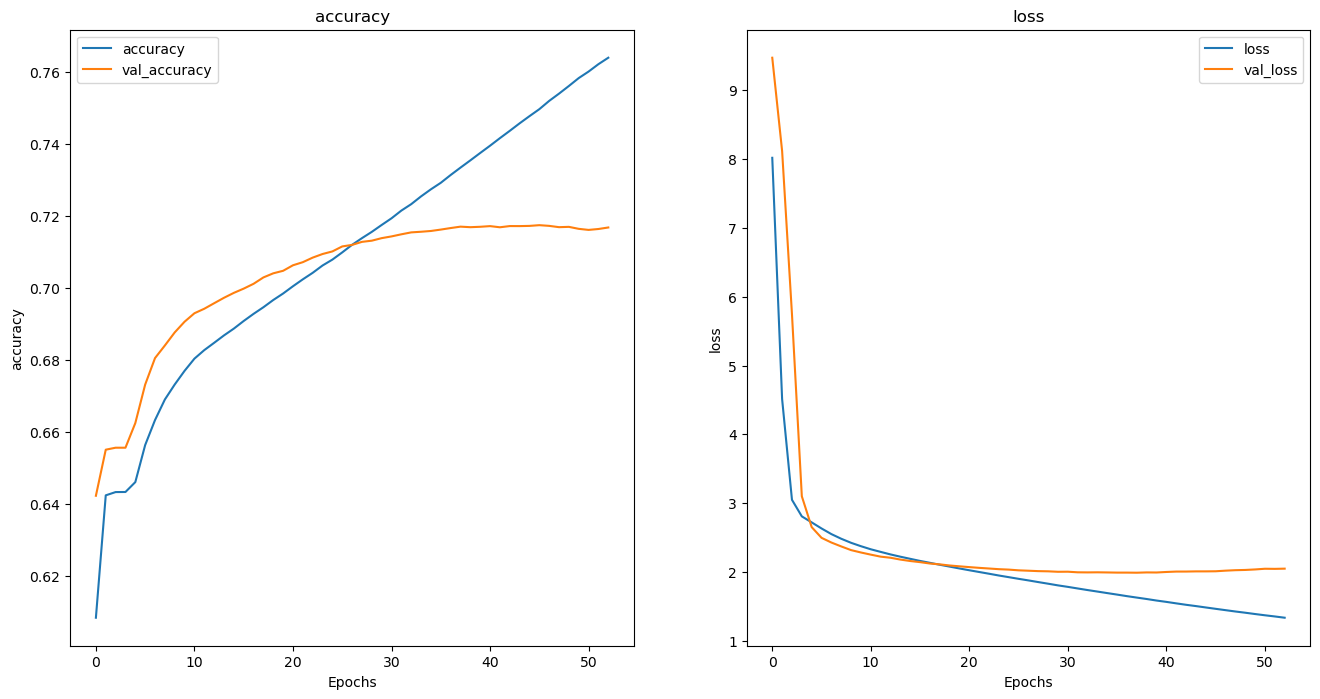

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [17]:
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 59s 324ms/step - loss: 9.5695 - accuracy: 0.5417 - val_loss: 9.4712 - val_accuracy: 0.6542
Epoch 2/200
172/172 [==============================] - 55s 321ms/step - loss: 7.2578 - accuracy: 0.6355 - val_loss: 7.9481 - val_accuracy: 0.6393
Epoch 3/200
172/172 [==============================] - 55s 321ms/step - loss: 5.0762 - accuracy: 0.6405 - val_loss: 5.5260 - val_accuracy: 0.6415
Epoch 4/200
172/172 [==============================] - 55s 321ms/step - loss: 3.6816 - accuracy: 0.6427 - val_loss: 3.9184 - val_accuracy: 0.6497
Epoch 5/200
172/172 [==============================] - 55s 322ms/step - loss: 3.1749 - accuracy: 0.6433 - val_loss: 3.1945 - val_accuracy: 0.6551
Epoch 6/200
172/172 [==============================] - 55s 322ms/step - loss: 2.9812 - accuracy: 0.6433 - val_loss: 3.0315 - val_accuracy: 0.6544
Epoch 7/200
172/172 [==============================] - 55s 321ms/step - loss: 2.8794 - accuracy: 0.6433 - val_loss: 3.0717 -

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

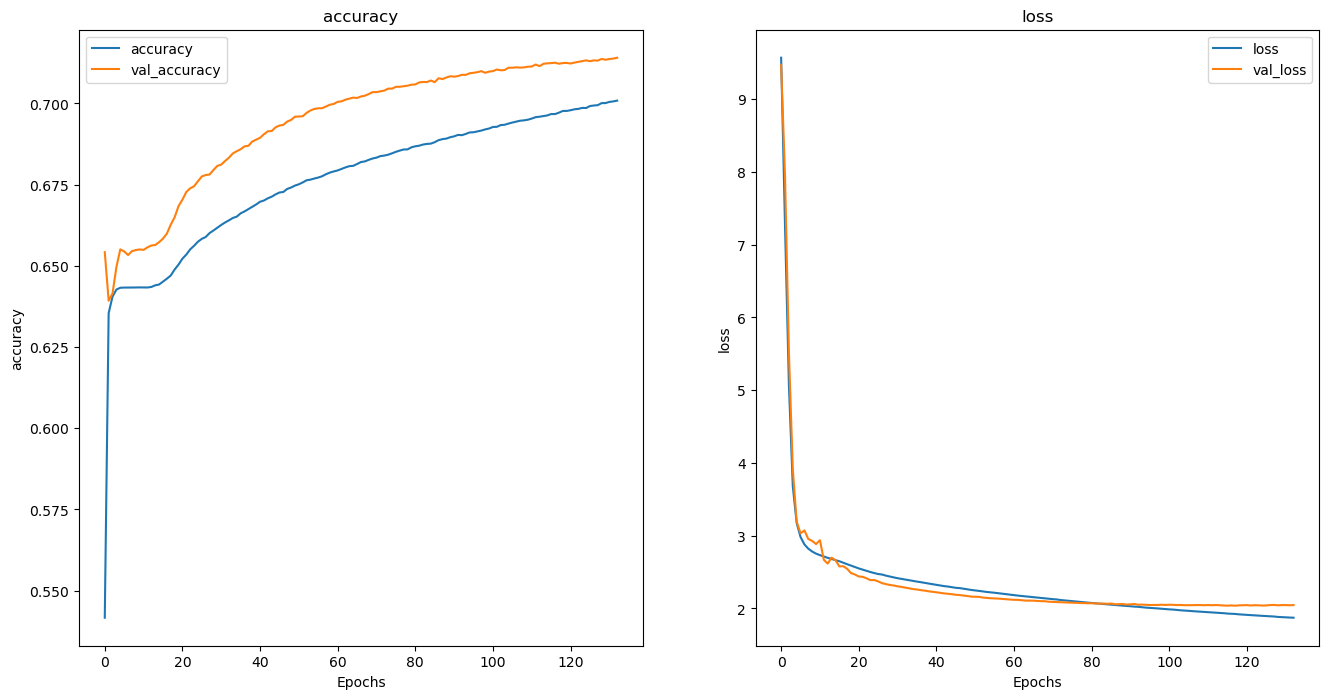

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [17]:
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 50s 269ms/step - loss: 9.7012 - accuracy: 0.5149 - val_loss: 9.2574 - val_accuracy: 0.6330
Epoch 2/200
172/172 [==============================] - 46s 267ms/step - loss: 8.1865 - accuracy: 0.6269 - val_loss: 8.3396 - val_accuracy: 0.6341
Epoch 3/200
172/172 [==============================] - 46s 267ms/step - loss: 6.6205 - accuracy: 0.6352 - val_loss: 6.4695 - val_accuracy: 0.6362
Epoch 4/200
172/172 [==============================] - 46s 267ms/step - loss: 5.0332 - accuracy: 0.6385 - val_loss: 4.8490 - val_accuracy: 0.6442
Epoch 5/200
172/172 [==============================] - 46s 267ms/step - loss: 3.9297 - accuracy: 0.6411 - val_loss: 3.7754 - val_accuracy: 0.6497
Epoch 6/200
172/172 [==============================] - 46s 267ms/step - loss: 3.3990 - accuracy: 0.6426 - val_loss: 3.6396 - val_accuracy: 0.6482
Epoch 7/200
172/172 [==============================] - 46s 267ms/step - loss: 3.1372 - accuracy: 0.6431 - val_loss: 3.4502 -

In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

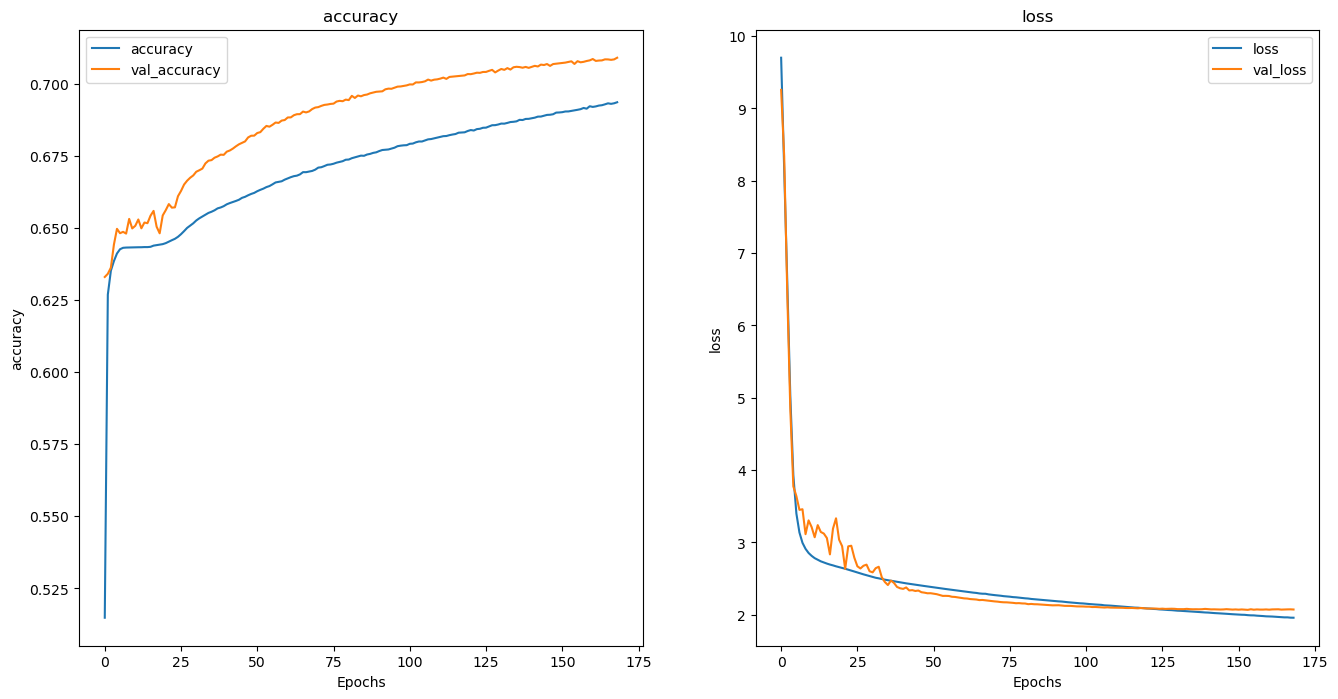

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [18]:
batch_size = 32
epochs = 100

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 50s 269ms/step - loss: 8.7258 - accuracy: 0.6139 - val_loss: 9.8053 - val_accuracy: 0.6364
Epoch 2/100
172/172 [==============================] - 46s 266ms/step - loss: 6.1355 - accuracy: 0.6430 - val_loss: 8.8406 - val_accuracy: 0.6557
Epoch 3/100
172/172 [==============================] - 46s 267ms/step - loss: 3.9261 - accuracy: 0.6434 - val_loss: 5.9684 - val_accuracy: 0.6557
Epoch 4/100
172/172 [==============================] - 46s 267ms/step - loss: 3.0476 - accuracy: 0.6434 - val_loss: 3.1707 - val_accuracy: 0.6557
Epoch 5/100
172/172 [==============================] - 46s 267ms/step - loss: 2.8348 - accuracy: 0.6434 - val_loss: 2.7840 - val_accuracy: 0.6557
Epoch 6/100
172/172 [==============================] - 46s 267ms/step - loss: 2.7494 - accuracy: 0.6435 - val_loss: 2.6575 - val_accuracy: 0.6558
Epoch 7/100
172/172 [==============================] - 46s 267ms/step - loss: 2.6918 - accuracy: 0.6468 - val_loss: 2.5509 -

In [23]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

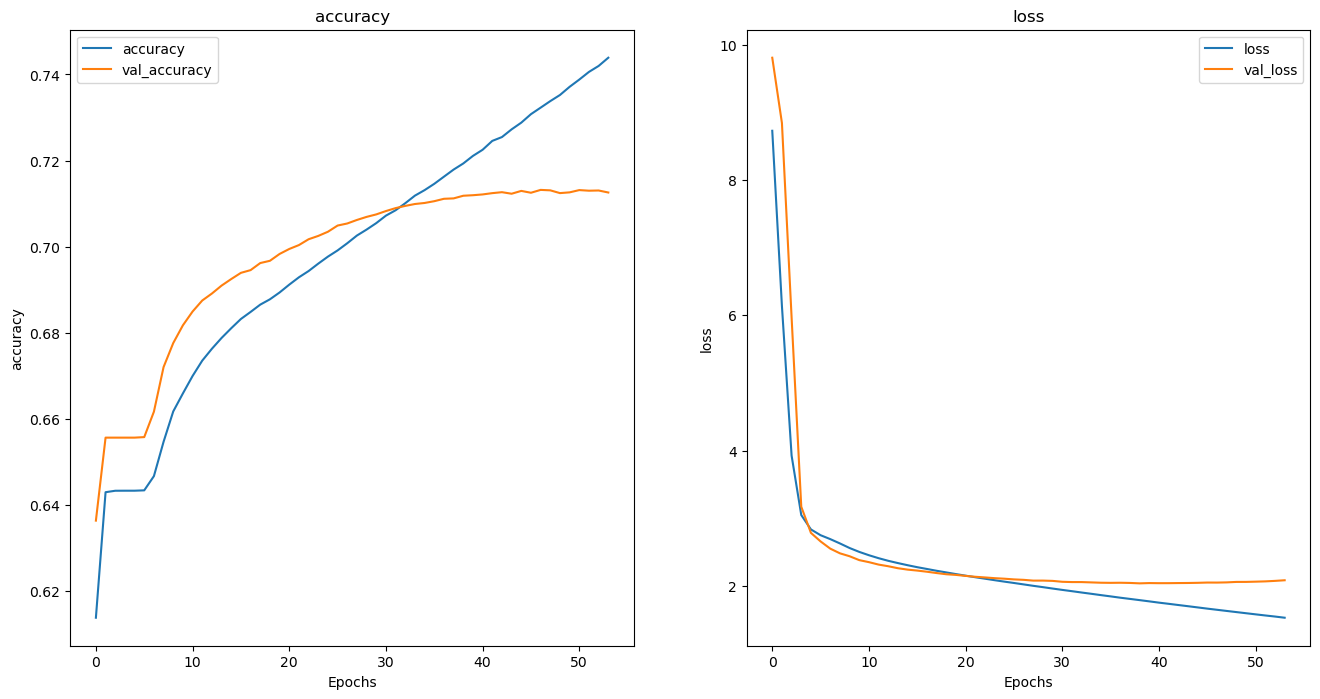

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [60]:
batch_size = 32
epochs = 100

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 15, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 57s 318ms/step - loss: 8.1526 - accuracy: 0.6028 - val_loss: 9.9111 - val_accuracy: 0.6224
Epoch 2/100
172/172 [==============================] - 54s 315ms/step - loss: 4.5860 - accuracy: 0.6343 - val_loss: 8.6510 - val_accuracy: 0.6517
Epoch 3/100
172/172 [==============================] - 54s 315ms/step - loss: 3.1367 - accuracy: 0.6379 - val_loss: 6.6783 - val_accuracy: 0.6517
Epoch 4/100
172/172 [==============================] - 54s 315ms/step - loss: 2.8872 - accuracy: 0.6380 - val_loss: 3.4280 - val_accuracy: 0.6517
Epoch 5/100
172/172 [==============================] - 54s 315ms/step - loss: 2.7836 - accuracy: 0.6427 - val_loss: 2.7295 - val_accuracy: 0.6618
Epoch 6/100
172/172 [==============================] - 54s 316ms/step - loss: 2.6819 - accuracy: 0.6543 - val_loss: 2.5554 - val_accuracy: 0.6725
Epoch 7/100
172/172 [==============================] - 54s 315ms/step - loss: 2.5916 - accuracy: 0.6612 - val_loss: 2.4667 -

In [75]:
batch_size = 32
epochs = 100

seq2seq_model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model2.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 48s 266ms/step - loss: 8.7104 - accuracy: 0.5992 - val_loss: 9.7985 - val_accuracy: 0.6471
Epoch 2/100
172/172 [==============================] - 45s 261ms/step - loss: 6.1168 - accuracy: 0.6311 - val_loss: 8.6786 - val_accuracy: 0.6517
Epoch 3/100
172/172 [==============================] - 45s 262ms/step - loss: 3.9324 - accuracy: 0.6375 - val_loss: 6.1560 - val_accuracy: 0.6517
Epoch 4/100
172/172 [==============================] - 45s 262ms/step - loss: 3.0858 - accuracy: 0.6379 - val_loss: 3.3476 - val_accuracy: 0.6517
Epoch 5/100
172/172 [==============================] - 45s 262ms/step - loss: 2.8746 - accuracy: 0.6379 - val_loss: 2.8428 - val_accuracy: 0.6517
Epoch 6/100
172/172 [==============================] - 45s 262ms/step - loss: 2.7890 - accuracy: 0.6381 - val_loss: 2.6734 - val_accuracy: 0.6532
Epoch 7/100
172/172 [==============================] - 45s 262ms/step - loss: 2.7224 - accuracy: 0.6433 - val_loss: 2.5991 -

In [76]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

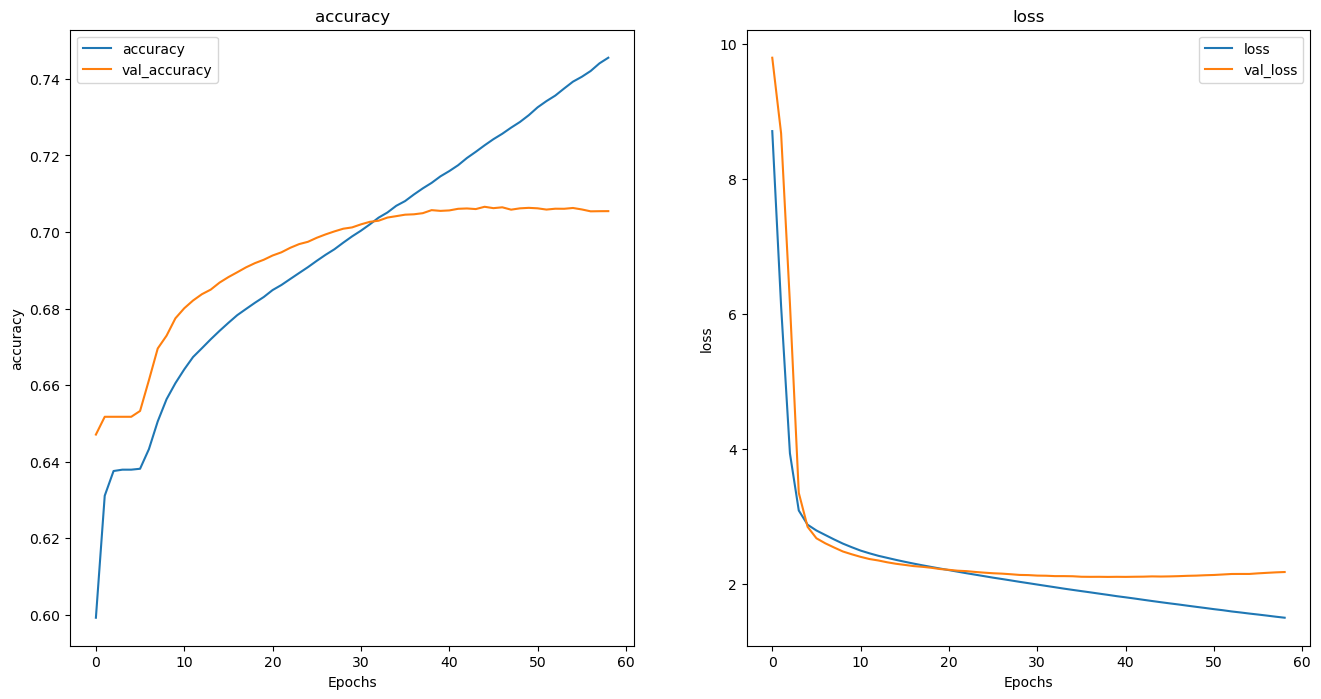

In [77]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [87]:
batch_size = 32
epochs = 100

seq2seq_model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model3.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/100
172/172 [==============================] - 78s 435ms/step - loss: 9.1628 - accuracy: 0.6050 - val_loss: 10.2809 - val_accuracy: 0.0225
Epoch 2/100
172/172 [==============================] - 73s 425ms/step - loss: 6.3135 - accuracy: 0.6257 - val_loss: 9.3885 - val_accuracy: 0.6516
Epoch 3/100
172/172 [==============================] - 73s 425ms/step - loss: 4.0277 - accuracy: 0.6362 - val_loss: 7.0442 - val_accuracy: 0.6517
Epoch 4/100
172/172 [==============================] - 73s 423ms/step - loss: 3.1535 - accuracy: 0.6379 - val_loss: 4.0696 - val_accuracy: 0.6517
Epoch 5/100
172/172 [==============================] - 73s 424ms/step - loss: 2.9247 - accuracy: 0.6379 - val_loss: 3.0317 - val_accuracy: 0.6517
Epoch 6/100
172/172 [==============================] - 73s 426ms/step - loss: 2.8199 - accuracy: 0.6388 - val_loss: 2.7404 - val_accuracy: 0.6539
Epoch 7/100
172/172 [==============================] - 73s 425ms/step - loss: 2.7359 - accuracy: 0.6458 - val_loss: 2.6095 

In [88]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

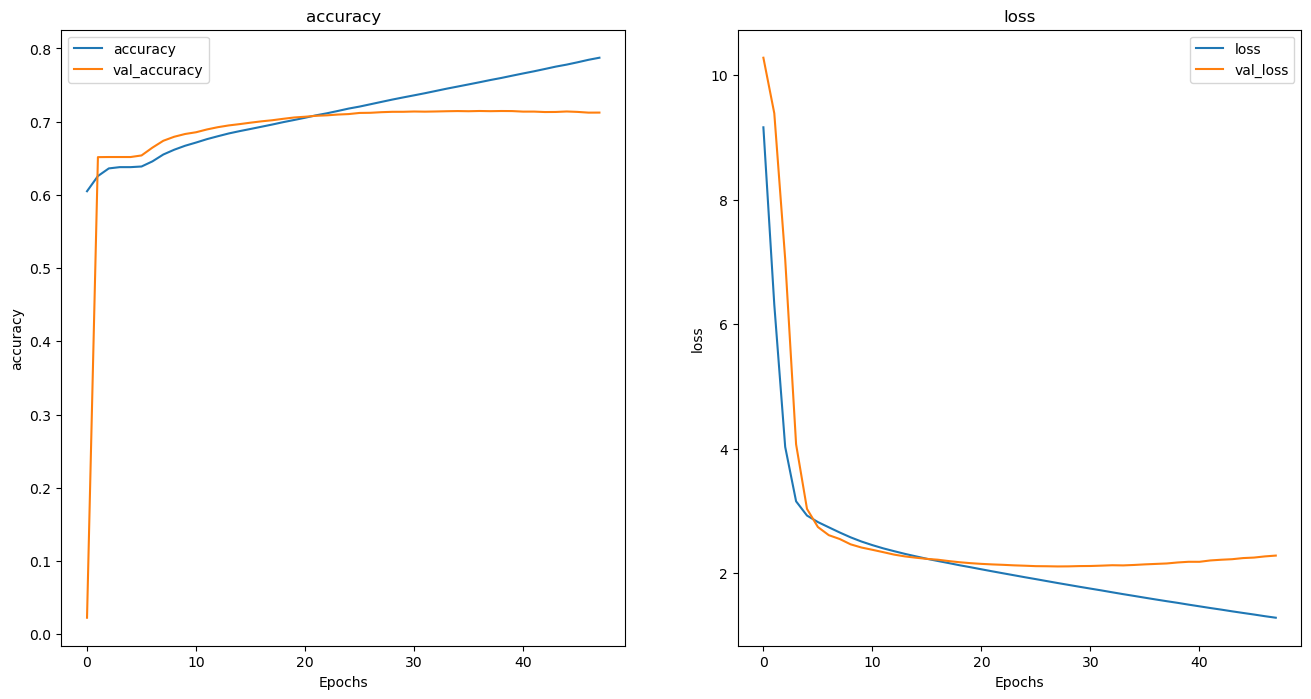

In [89]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [70]:
batch_size = 32
epochs = 200

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/200
172/172 [==============================] - 45s 244ms/step - loss: 9.7124 - accuracy: 0.5907 - val_loss: 10.5404 - val_accuracy: 0.0093
Epoch 2/200
172/172 [==============================] - 42s 244ms/step - loss: 8.1425 - accuracy: 0.6318 - val_loss: 9.6735 - val_accuracy: 0.6517
Epoch 3/200
172/172 [==============================] - 42s 246ms/step - loss: 6.6542 - accuracy: 0.6357 - val_loss: 7.6812 - val_accuracy: 0.6517
Epoch 4/200
172/172 [==============================] - 42s 244ms/step - loss: 5.1569 - accuracy: 0.6374 - val_loss: 4.2979 - val_accuracy: 0.6517
Epoch 5/200
172/172 [==============================] - 42s 245ms/step - loss: 3.9297 - accuracy: 0.6379 - val_loss: 3.3041 - val_accuracy: 0.6517
Epoch 6/200
172/172 [==============================] - 42s 244ms/step - loss: 3.2966 - accuracy: 0.6379 - val_loss: 2.9506 - val_accuracy: 0.6517
Epoch 7/200
172/172 [==============================] - 42s 244ms/step - loss: 3.0315 - accuracy: 0.6379 - val_loss: 2.8288 

KeyboardInterrupt: 

In [51]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

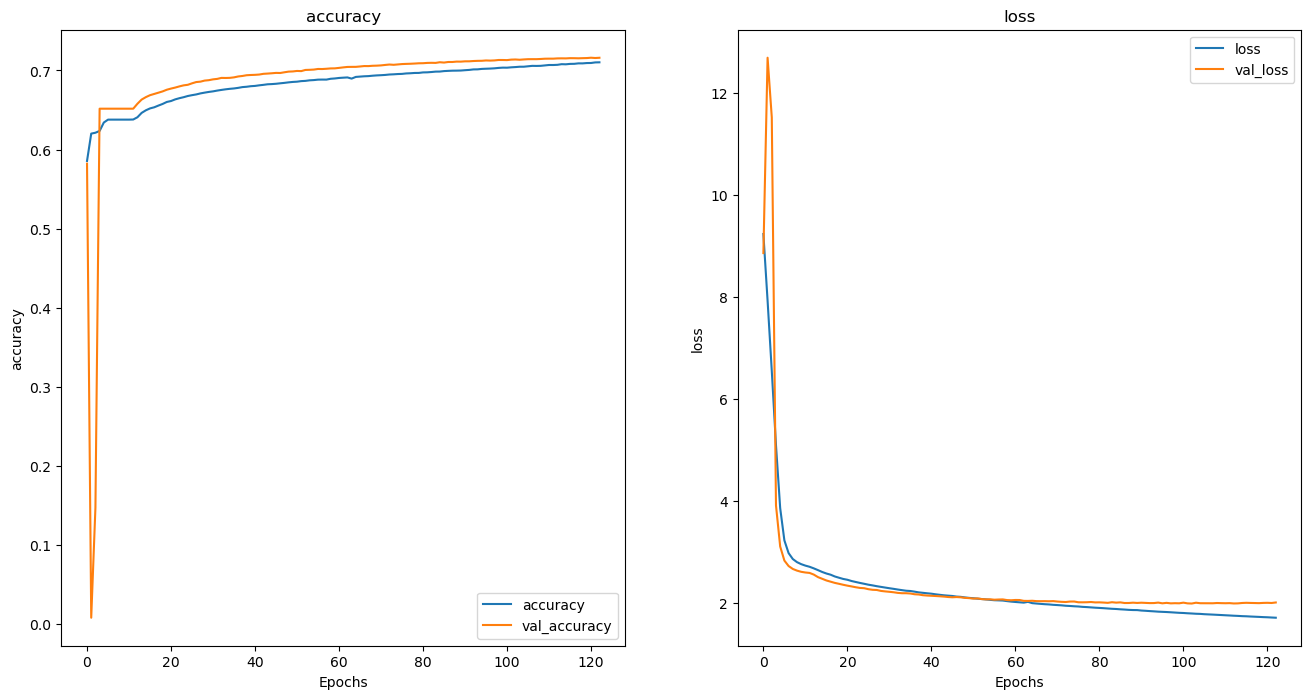

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [50]:
batch_size = 32
epochs = 50

seq2seq_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

Epoch 1/50
172/172 [==============================] - 86s 486ms/step - loss: 3.8723 - accuracy: 0.6128 - val_loss: 3.9109 - val_accuracy: 0.6375
Epoch 2/50
172/172 [==============================] - 83s 484ms/step - loss: 2.7085 - accuracy: 0.6397 - val_loss: 5.1727 - val_accuracy: 0.6507
Epoch 3/50
172/172 [==============================] - 83s 483ms/step - loss: 2.5858 - accuracy: 0.6513 - val_loss: 3.3521 - val_accuracy: 0.6683
Epoch 4/50
172/172 [==============================] - 83s 484ms/step - loss: 2.4798 - accuracy: 0.6604 - val_loss: 2.4767 - val_accuracy: 0.6751
Epoch 5/50
172/172 [==============================] - 83s 484ms/step - loss: 2.3923 - accuracy: 0.6673 - val_loss: 2.3632 - val_accuracy: 0.6822
Epoch 6/50
172/172 [==============================] - 83s 483ms/step - loss: 2.3192 - accuracy: 0.6725 - val_loss: 2.3067 - val_accuracy: 0.6856
Epoch 7/50
172/172 [==============================] - 84s 490ms/step - loss: 2.2547 - accuracy: 0.6762 - val_loss: 2.2480 - val_ac

In [51]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

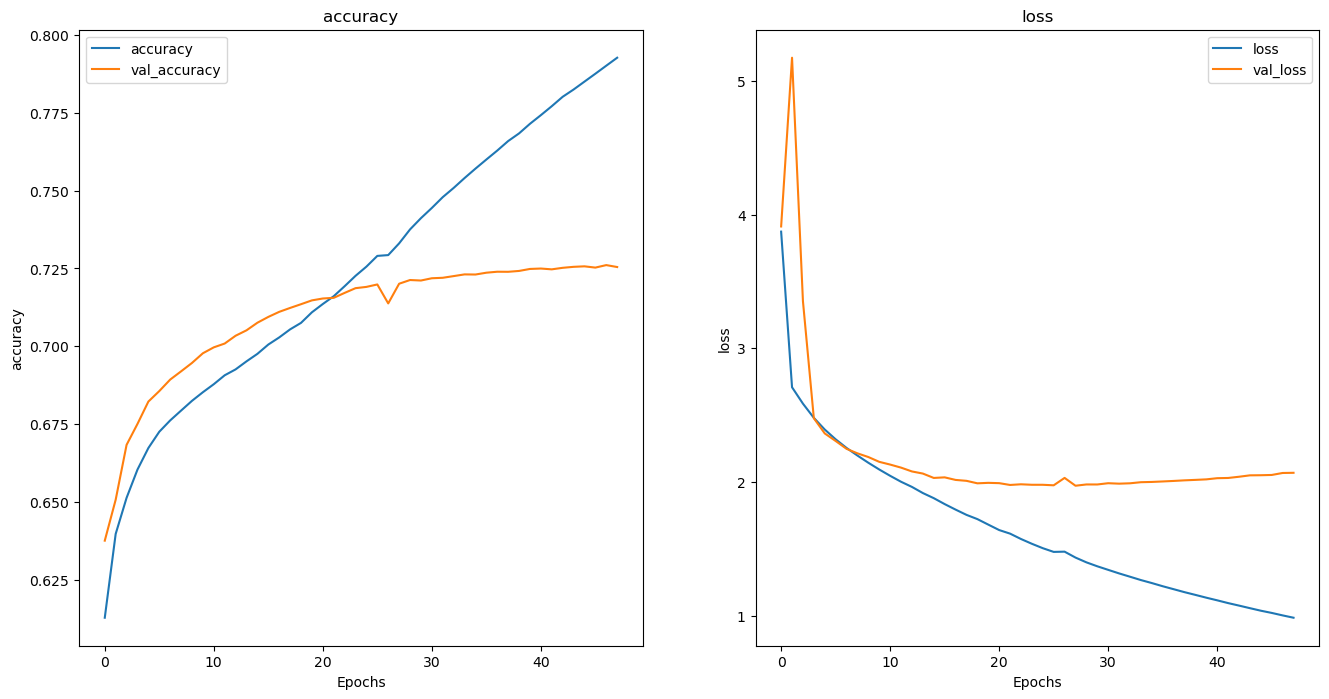

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [44]:
batch_size = 32
epochs = 50

seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
172/172 [==============================] - 105s 594ms/step - loss: 4.1350 - accuracy: 0.4441 - val_loss: 9.0177 - val_accuracy: 0.3801
Epoch 2/50
172/172 [==============================] - 102s 591ms/step - loss: 3.3085 - accuracy: 0.4903 - val_loss: 7.2529 - val_accuracy: 0.3683
Epoch 3/50
172/172 [==============================] - 102s 591ms/step - loss: 2.7678 - accuracy: 0.5226 - val_loss: 4.7674 - val_accuracy: 0.4586
Epoch 4/50
172/172 [==============================] - 102s 593ms/step - loss: 2.2712 - accuracy: 0.5681 - val_loss: 3.2507 - val_accuracy: 0.5332
Epoch 5/50
172/172 [==============================] - 97s 564ms/step - loss: 1.8440 - accuracy: 0.6218 - val_loss: 3.3396 - val_accuracy: 0.5412
Epoch 6/50
172/172 [==============================] - 97s 562ms/step - loss: 1.4988 - accuracy: 0.6730 - val_loss: 3.4785 - val_accuracy: 0.5441
Epoch 7/50
172/172 [==============================] - 97s 562ms/step - loss: 1.2137 - accuracy: 0.7210 - val_loss: 3.6020 - va

In [45]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

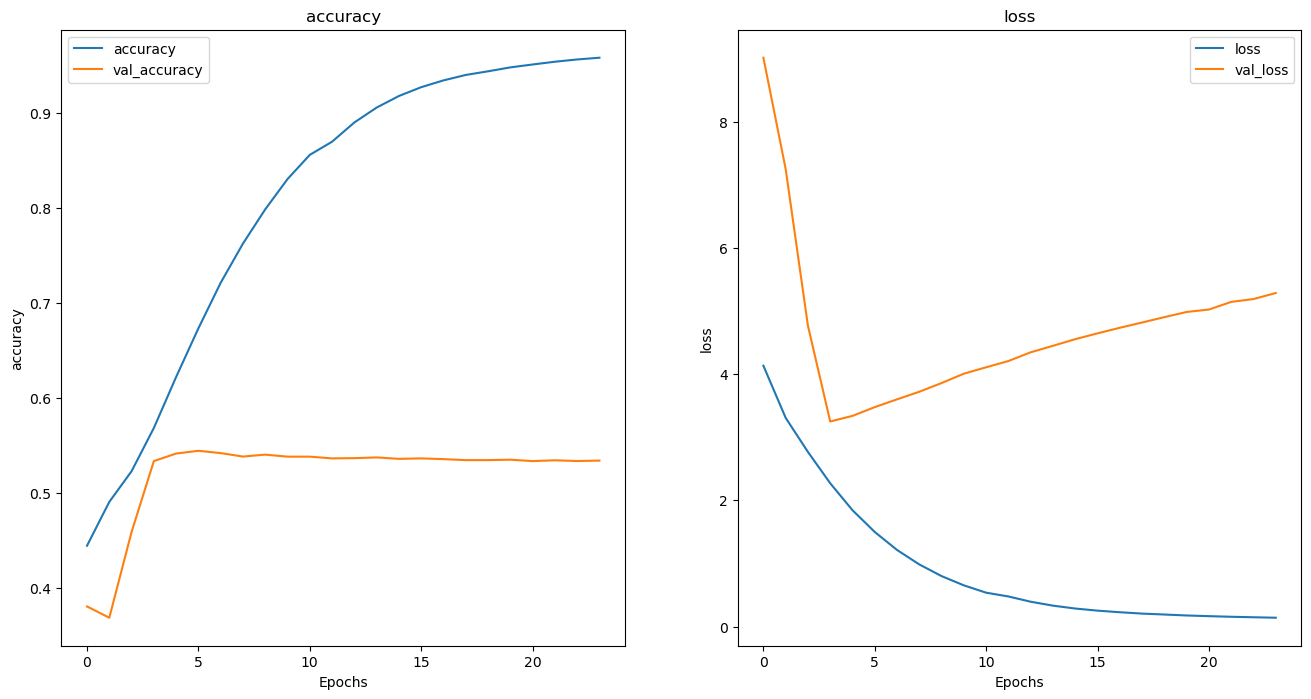

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [51]:
batch_size = 32
epochs = 50

seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.25,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
207/207 [==============================] - 60s 276ms/step - loss: 4.2461 - accuracy: 0.4379 - val_loss: 13.6218 - val_accuracy: 0.0404
Epoch 2/50
207/207 [==============================] - 56s 272ms/step - loss: 3.5078 - accuracy: 0.4816 - val_loss: 7.7277 - val_accuracy: 0.0765
Epoch 3/50
207/207 [==============================] - 56s 272ms/step - loss: 3.0827 - accuracy: 0.5076 - val_loss: 3.3816 - val_accuracy: 0.5079
Epoch 4/50
207/207 [==============================] - 56s 272ms/step - loss: 2.7304 - accuracy: 0.5299 - val_loss: 3.3126 - val_accuracy: 0.5159
Epoch 5/50
207/207 [==============================] - 57s 274ms/step - loss: 2.4076 - accuracy: 0.5571 - val_loss: 3.5522 - val_accuracy: 0.4931
Epoch 6/50
207/207 [==============================] - 57s 273ms/step - loss: 2.1205 - accuracy: 0.5885 - val_loss: 3.2759 - val_accuracy: 0.5378
Epoch 7/50
207/207 [==============================] - 57s 275ms/step - loss: 1.8667 - accuracy: 0.6220 - val_loss: 3.3967 - val_a

In [52]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.title(metric)
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

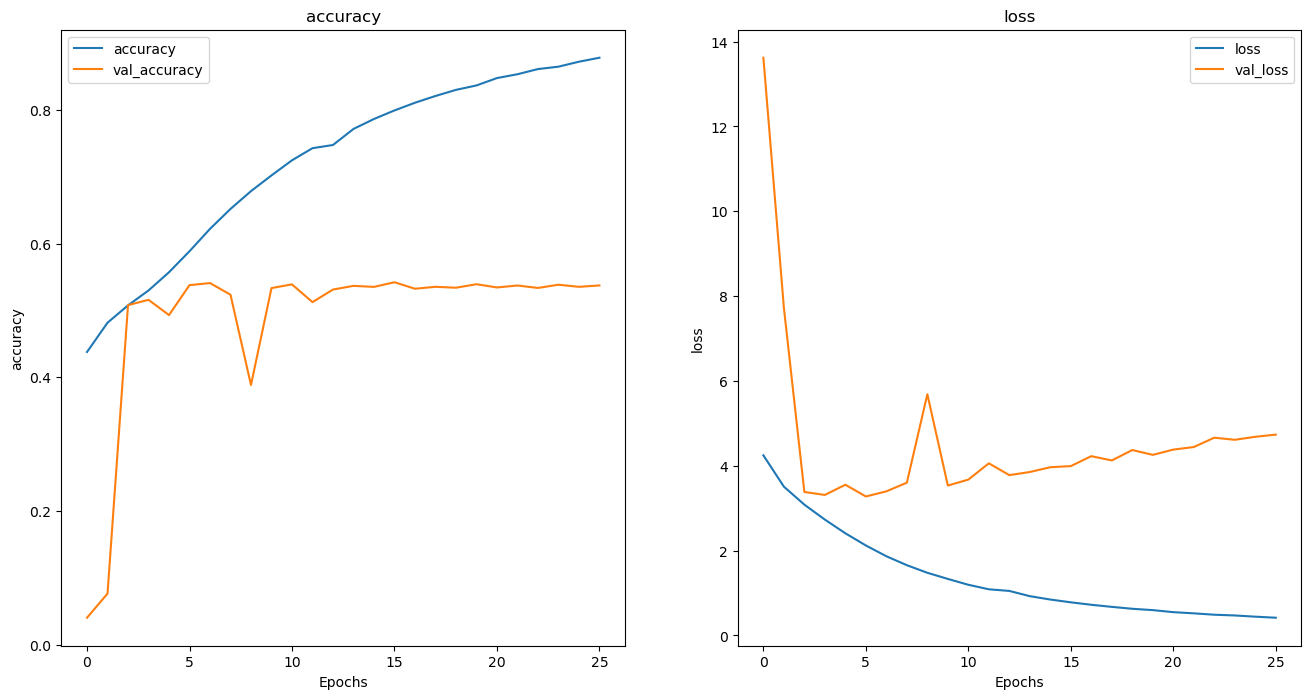

In [53]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [41]:
batch_size = 32
epochs = 50

seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = seq2seq_model.fit([encoder_input_data, decoder_input_data],
                            np.expand_dims(decoder_target_data, -1),
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.1,
                            callbacks = [EarlyStopping(verbose = 1, patience = 20, restore_best_weights = True)])

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
207/207 [==============================] - 52s 241ms/step - loss: 4.2546 - accuracy: 0.4374 - val_loss: 7.9595 - val_accuracy: 0.1476
Epoch 2/50
207/207 [==============================] - 49s 238ms/step - loss: 3.4491 - accuracy: 0.4867 - val_loss: 14.6806 - val_accuracy: 0.0618
Epoch 3/50
207/207 [==============================] - 49s 238ms/step - loss: 3.0847 - accuracy: 0.5085 - val_loss: 3.4034 - val_accuracy: 0.5022
Epoch 4/50
207/207 [==============================] - 49s 239ms/step - loss: 2.6818 - accuracy: 0.5347 - val_loss: 3.3117 - val_accuracy: 0.5082
Epoch 5/50
207/207 [==============================] - 49s 239ms/step - loss: 2.3565 - accuracy: 0.5632 - val_loss: 3.5233 - val_accuracy: 0.5093
Epoch 6/50
207/207 [==============================] - 49s 239ms/step - loss: 2.0586 - accuracy: 0.5975 - val_loss: 3.2640 - val_accuracy: 0.5390
Epoch 7/50
207/207 [==============================] - 49s 238ms/step - loss: 1.8069 - accuracy: 0.6313 - val_loss: 3.3345 - val_a

## Extraer modelos codificador y decodificador

In [17]:
#si se entrena la que no tiene densas ni dropout
def extract_decoder_model(model): #**
    latent_dim = model.get_layer('Encoder-Model').output_shape[-1]
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_emb_dropout = model.get_layer('Decoder-Embedding-Dropout')(dec_emb)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb_dropout)
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])
    decoder_dense = model.get_layer('Decoder-Dense')(gru_out)
    decoder_dropout = model.get_layer('Decoder-Dropout')(decoder_dense)
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(decoder_dropout)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input], [dense_out, gru_state_out])
    return decoder_model

In [18]:
#sin dropout
def extract_decoder_model(model): #**
    latent_dim = model.get_layer('Encoder-Model').output_shape[-1]
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])
    decoder_dense = model.get_layer('Decoder-Dense')(gru_out)
    decoder_dropout = model.get_layer('Decoder-Dropout')(decoder_dense)
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(decoder_dropout)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input], [dense_out, gru_state_out])
    return decoder_model

In [18]:
encoder_model = seq2seq_model.get_layer('Encoder-Model')
for layer in encoder_model.layers:
    layer.trainable = False

decoder_model = extract_decoder_model(seq2seq_model)
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 256)    6145792     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Embedding-Dropout (Drop (None, None, 256)    0           Decoder-Word-Embedding[1][0]     
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 256)    1024        Decoder-Embedding-Dropout[1][0]  
____________________________________________________________________________________________

## Obtener resúmenes extractivos

In [19]:
def obtenerResumen(resumen):
    max_len = target_proc.padding_maxlen
    raw_input_text = resumen

    raw_tokenized = source_proc.transform([raw_input_text])
    encoding = encoder_model.predict(raw_tokenized)
    original_encoding = encoding
    state_value = np.array(target_proc.token2id['_start_']).reshape(1, 1)

    decoded_sentence = []
    stop_condition = False
    while not stop_condition:
        preds, st = decoder_model.predict([state_value, encoding])
        pred_idx = np.argmax(preds[:, :, 2:]) + 2
        pred_word_str = target_proc.id2token[pred_idx]

        if pred_word_str == '_end_' or len(decoded_sentence) >= max_len:
            stop_condition = True
            break
        decoded_sentence.append(pred_word_str)

        # update the decoder for the next word
        encoding = st
        state_value = np.array(pred_idx).reshape(1, 1)
    
    return ' '.join(decoded_sentence)

In [21]:
def clear_spaces(lines):
  ans = lines.copy()
  ans = [line.strip() for line in ans]
  ans = [line for line in ans if line != "" and len(line) > 0 and line !="\n"]
  return ans

def clean_currency(lines):
  lines_list = lines.splitlines()    
  ans = lines_list.copy()
  for i in range(len(ans)):
    words = ans[i].split(" ") 
    for j in range(len(words)):
      word = words[j].strip()
      k = 1
      is_currency = False
      is_interrog = False
      is_qmarks = False
      while(k+1 < len(word) and not is_currency):
        if( (word[k-1].islower() and word[k] == '.' and word[k+1].isupper() ) or (word[k-1].islower() and word[k] == '.' and word[k+1].islower()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].islower()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].isupper()) or (word[k-1].isdigit() and word[k] == '.' and word[k+1].isupper()) or (word[k-1].isdigit() and word[k] == '.' and word[k+1].islower()) or (word[k-1].islower() and word[k] == '.' and word[k+1].isdigit()) or (word[k-1].isupper() and word[k] == '.' and word[k+1].isdigit()) or (word[k-1] == '"' and word[k] == '.' and word[k+1].isupper()) or (word[k-1] == '"' and word[k] == '.' and word[k+1].islower()) or (word[k-1] == '"' and word[k] == '.' and word[k+1] == '"') or (word[k-1].isdigit() and word[k] == '.' and word[k+1] == '"') or (word[k-1].isupper() and word[k] == '.' and word[k+1] == '"') or word[k-1] == "'" and word[k] == '.' and word[k+1].isupper() or word[k-1] == "'" and word[k] == '.' and word[k+1].islower() or word[k-1].islower() and word[k] == '.' and word[k+1] == "'" or word[k-1].isupper() and word[k] == '.' and word[k+1] == "'" or word[k-1] == "'" and word[k] == '.' and word[k+1].isdigit() or word[k-1] == "'" and word[k] == '.' and word[k+1] == "'" or word[k-1].islower() and word[k] == '.' and word[k+1] == "\x89" or word[k-1].isupper() and word[k] == '.' and word[k+1] == "\x89" or word[k-1].isdigit() and word[k] == '.' and word[k+1] == "\x89" or word[k-1] == ')' and word[k] == '.' and word[k+1].isupper() or word[k-1] == ')' and word[k] == '.' and word[k+1].islower() or word[k-1].islower() and word[k] == '.' and word[k+1] == '(' or word[k-1].isupper() and word[k] == '.' and word[k+1] == '(' or word[k-1] == ')' and word[k] == '.' and word[k+1].isdigit() or word[k-1].isdigit() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1].islower() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1].isupper() and word[k] == '.' and word[k+1] == '‰Û' or word[k-1] == '}' and word[k] == '.' and word[k+1].isupper() or word[k-1] == '}' and word[k] == '.' and word[k+1].islower() or word[k-1] == '}' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == ']' and word[k] == '.' and word[k+1].isupper() or word[k-1] == ']' and word[k] == '.' and word[k+1].islower() or word[k-1] == ']' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == '%' and word[k] == '.' and word[k+1].isdigit() or word[k-1] == '%' and word[k] == '.' and word[k+1].islower() or word[k-1] == '%' and word[k] == '.' and word[k+1].isupper() ):
          is_currency = True
        if( word[k-1].islower() and word[k] == '?' and word[k+1].isupper() or word[k-1].islower() and word[k] == '?' and word[k+1].islower() ):
          is_interrog = True
        if( word[k-1] == '.' and word[k] == '"' and word[k+1].isupper() ):
          is_qmarks = True
        k += 1
      if(is_currency):
        word = word.replace(".",". ",1)
      if(is_interrog):
        word = word.replace("?","? ",1)
      if(is_qmarks):
        word = word.replace('"','" ',1)
      words[j] = str(word)
    ans[i] = " ".join(words) 
  return ans

def split_sentences(text):
    sentence_enders = re.compile(r"""
        # Split sentences on whitespace between them.
        (?:               # Group for two positive lookbehinds.
          (?<=[.])      # Either an end of sentence punct,
        | (?<=[.]['"])  # or end of sentence punct and quote.
        )                 # End group of two positive lookbehinds.
        (?<!  \bMr\.   )    # Don't end sentence on "Mr."
        (?<!  \bMrs\.  )    # Don't end sentence on "Mrs."
        (?<!  \bMs\.  )    # Don't end sentence on "Mrs."
        (?<!  \bGov\.  )    # Don't end sentence on "Gov."
        (?<!  \bJr\.   )    # Don't end sentence on "Jr."
        (?<!  \bDr\.   )    # Don't end sentence on "Dr."
        (?<!  \bProf\. )    # Don't end sentence on "Prof."
        (?<!  \bSr\.   )    # Don't end sentence on "Sr."
        (?<!  \bU\.S\.   )   # Don't end sentence on "U.S."
        (?<!  \bD\.C\.   )   # Don't end sentence on "D.C."
        (?<!  \bco\.   )    # Don't end sentence on "co."
        (?<!  \bCorp\.   )    # Don't end sentence on "co."
        (?<!  \bSen\.   )    # Don't end sentence on "co."
        (?<!  \btenn\.   )  # Don't end sentence on "tenn."
        (?<!  \bJan\.   )  # Don't end sentence on "Jan."
        (?<!  \bFeb\.   )  # Don't end sentence on "Feb."
        (?<!  \bMar\.   )  # Don't end sentence on "Mar."
        (?<!  \bApr\.   )  # Don't end sentence on "Apr."
        (?<!  \bMay\.   )  # Don't end sentence on "May."
        (?<!  \bJun\.   )  # Don't end sentence on "Jun."
        (?<!  \bJul\.   )  # Don't end sentence on "Jul."
        (?<!  \bAug\.   )  # Don't end sentence on "Aug."
        (?<!  \bSep\.   )  # Don't end sentence on "Sep."
        (?<!  \bSept\.   )  # Don't end sentence on "Sep."
        (?<!  \bOct\.   )  # Don't end sentence on "Oct."
        (?<!  \bNov\.   )  # Don't end sentence on "Nov."
        (?<!  \bDec\.   )  # Don't end sentence on "Dec."
        (?<!  \bWSJ\.   )  # Don't end sentence on "WSJ."
        (?<!  \bvs\.   )  # Don't end sentence on "vs. "
        (?<!  \bVS\.   )  # Don't end sentence on "VS. "
        (?<!  \bNo\.   )  # Don't end sentence on "No. "
        (?<!  \b[A-Z]\.   )  # Don't end sentence on a capital letter.
        (?<!  \ba\.|\bb\.|\bc\.|\bd\.|\be\.|\bf\.|\bg\.|\bh\.|\bi\.|\bj\.|\bk\.|\bl\.|\bm\.|\bn\.|\bo\.|\bp\.|\bq\.|\br\.|\bu\.|\bv\.|\bw\.|\bx\.|\by\.|\bz\. )  # Don't end sentence on a letter; s and t are removed (ex. don't.)
        (?<!  \b\s1\.\b|\b\s2\.\b|\b\s3\.\b|\b\s4\.\b|\b\s5\.\b|\b\s6\.\b|\b\s7\.\b|\b\s8\.\b|\b\s9\.\b ) # Don't end sentence on a number of one digit.
        (?<!  \b\s10\.\b|\b\s11\.\b|\b\s12\.\b|\b\s13\.\b|\b\s14\.\b|\b\s15\.\b|\b\s16\.\b|\b\s17\.\b|\b\s18\.\b|\b\s19\.\b|\b\s20\.\b|\b\s21\.\b|\b\s22\.\b|\b\s23\.\b|\b\s25\.\b|\b\s26\.\b|\b\s27\.\b|\b\s28\.\b|\b\s29\.\b|\b\s30\.\b|\b\s31\.\b )  # Don't end sentence on a number of two digit.


        \s+               # Split on whitespace between sentences.
        """, 
        re.VERBOSE)
    lines_sw = ' '.join(text)
    lines = sentence_enders.split(lines_sw)
    return lines

def make_labels_summary(text_list): #funcion que crea el label que representa cuales oraciones del resumen están dentro de la noticia
    all_document_sentences = []


    text_list_cleaned = clean_currency(text_list)

    text_list_cleaned_special = split_sentences(text_list_cleaned)


    for doc_sent in text_list_cleaned_special:
        all_document_sentences.append(doc_sent)

    return all_document_sentences

In [22]:
def textEncoder(text):
    sentences = make_labels_summary(text)
    sentence_embedding = []
    for sentence in sentences:
        row_token = source_proc.transform([sentence])
        encoded = encoder_model.predict(row_token)
        sentence_embedding.append(encoded)
    return sentence_embedding        

In [23]:
def euclidian_distance(resumen_abst_encoded, resumen_gt):
    d_list = [] 
    i_list = []
    j_list = []
    
    for i, or_abstractivo in enumerate(resumen_abst_encoded):
        for j, or_gt in enumerate(resumen_gt):
            d = np.linalg.norm(or_abstractivo - or_gt)
            d_list.append(d)
            i_list.append(i)
            j_list.append(j) 
    return d_list, i_list, j_list

In [24]:
def extractive_summary(d_list, i_list, j_list, resumen_abstractivo_split, resumen_extractivo_split):
    
    d_array = np.array(d_list)
    i_array = np.array(i_list)
    j_array = np.array(j_list)
    
    or_resumen_abs = []
    or_gt_extract = []
    dmin = np.argsort(d_array)[:5]
    
    for n in dmin:
        or_resumen_abs.append(resumen_abstractivo_split[i_array[n]])
        or_gt_extract.append(resumen_extractivo_split[j_array[n]])
        
    return or_resumen_abs, or_gt_extract

In [25]:
data_list = []

# Iterar sobre los resúmenes en train_source_docs y train_target_docs
for resumen, resumen_ext in tqdm(zip(test_source_docs, test_target_docs), total=len(test_source_docs)):
    resumen_abstractivo = obtenerResumen(resumen) 
    resumen_abstractivo_split = make_labels_summary(resumen_abstractivo) 
    resumen_abst_encoded = textEncoder(resumen_abstractivo)
    resumen_extractivo_split = make_labels_summary(resumen)
    resumen_gt = textEncoder(resumen)
    d_list, i_list, j_list = euclidian_distance(resumen_abst_encoded, resumen_gt)
    or_resumen_abs, or_gt_extract = extractive_summary(d_list, i_list, j_list, resumen_abstractivo_split, resumen_extractivo_split)

    extractive_summary_str = ' '.join(or_gt_extract)  
    
    data_list.append({
        "original_summary": resumen_ext,
        "extractive_summary": extractive_summary_str
    })

with open("", "w") as archivo:
    json.dump(data_list, archivo, indent=4)


100%|██████████| 510/510 [28:44<00:00,  3.38s/it]

Los resúmenes han sido guardados en el archivo test_summary.json.


In [53]:
from rouge_score import rouge_scorer

with open('', 'r', encoding="utf-8") as f:
    lines = json.load(f)
original_summaries = [line['original_summary'] for line in lines]
extractive_summaries = [line['extractive_summary'] for line in lines]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

rouge1_precision = []
rouge1_recall = []
rouge1_fmeasure = []
rougeL_precision = []
rougeL_recall = []
rougeL_fmeasure = []

for original_summary, extractive_summary in zip(original_summaries, extractive_summaries):
    scores = scorer.score(original_summary, extractive_summary)
    rouge1_precision.append(scores['rouge1'].precision)
    rouge1_recall.append(scores['rouge1'].recall)
    rouge1_fmeasure.append(scores['rouge1'].fmeasure)
    rougeL_precision.append(scores['rougeL'].precision)
    rougeL_recall.append(scores['rougeL'].recall)
    rougeL_fmeasure.append(scores['rougeL'].fmeasure)

rouge1_precision_avg = sum(rouge1_precision) / len(rouge1_precision)
rouge1_recall_avg = sum(rouge1_recall) / len(rouge1_recall)
rouge1_fmeasure_avg = sum(rouge1_fmeasure) / len(rouge1_fmeasure)
rougeL_precision_avg = sum(rougeL_precision) / len(rougeL_precision)
rougeL_recall_avg = sum(rougeL_recall) / len(rougeL_recall)
rougeL_fmeasure_avg = sum(rougeL_fmeasure) / len(rougeL_fmeasure)

print("ROUGE-1:")
print(f"Precisión: {rouge1_precision_avg:.4f}")
print(f"Recall: {rouge1_recall_avg:.4f}")
print(f"F1-score: {rouge1_fmeasure_avg:.4f}")

print("\nROUGE-L:")
print(f"Precisión: {rougeL_precision_avg:.4f}")
print(f"Recall: {rougeL_recall_avg:.4f}")
print(f"F1-score: {rougeL_fmeasure_avg:.4f}")


ROUGE-1:
Precisión: 0.6411
Recall: 0.6461
F1-score: 0.6287

ROUGE-L:
Precisión: 0.4346
Recall: 0.4429
F1-score: 0.4287


Most of the pieces for this step come from prior steps in this tutorial. In this step, we will fine-tune the seq2seq model  to predict docstring embeddings instead of docstrings.

In [62]:
inp = Input(shape=(train_source_emb.shape[1],))
x = Dense(train_target_emb.shape[1], use_bias=False)(inp)
# x = BatchNormalization()(x)
# x = Dense(train_target_emb.shape[1])(x)
modal_model = Model([inp], x)
modal_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262144    
Total params: 262,144
Trainable params: 262,144
Non-trainable params: 0
_________________________________________________________________


In [63]:
#batch_size antes 1200 
modal_model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='cosine_similarity', metrics=['accuracy'])

batch_size = 32
epochs = 20
history = modal_model.fit([train_source_emb], train_target_emb,
                          batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
207/207 [==============================] - 1s 3ms/step - loss: -0.6160 - accuracy: 0.0611 - val_loss: -0.7641 - val_accuracy: 0.1078
Epoch 2/20
207/207 [==============================] - 0s 2ms/step - loss: -0.7601 - accuracy: 0.1452 - val_loss: -0.7942 - val_accuracy: 0.1896
Epoch 3/20
207/207 [==============================] - 0s 2ms/step - loss: -0.7837 - accuracy: 0.1796 - val_loss: -0.8083 - val_accuracy: 0.2101
Epoch 4/20
207/207 [==============================] - 0s 2ms/step - loss: -0.7986 - accuracy: 0.1934 - val_loss: -0.8182 - val_accuracy: 0.2101
Epoch 5/20
207/207 [==============================] - 0s 2ms/step - loss: -0.8101 - accuracy: 0.2016 - val_loss: -0.8246 - val_accuracy: 0.2210
Epoch 6/20
207/207 [==============================] - 0s 2ms/step - loss: -0.8192 - accuracy: 0.2133 - val_loss: -0.8296 - val_accuracy: 0.2319
Epoch 7/20
207/207 [==============================] - 0s 2ms/step - loss: -0.8268 - accuracy: 0.2286 - val_loss: -0.8344 - val_accuracy:

In [47]:
#batch_size antes 1200 
modal_model.compile(optimizer=optimizers.Nadam(lr=0.0001), loss='cosine_proximity', metrics=['accuracy'])

batch_size = 32
epochs = 20
history = modal_model.fit([train_source_emb], train_target_emb,
                          batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20


ValueError: in user code:

    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\training.py:850 train_function  *
        return step_function(self, iterator)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\training.py:840 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\training.py:833 run_step  **
        outputs = model.train_step(data)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\training.py:792 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:187 __call__
        self.build(y_pred)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:136 build
        self._losses = nest.map_structure(self._get_loss_object, self._losses)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\util\nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\util\nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:276 _get_loss_object
        loss = losses_mod.get(loss)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\losses.py:2078 get
        return deserialize(identifier)
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\losses.py:2037 deserialize
        printable_module_name='loss function')
    C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:703 deserialize_keras_object
        .format(printable_module_name, object_name))

    ValueError: Unknown loss function: cosine_proximity. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


Warning: the results of this portion are minimal and not very good.  We leave it as an exercise to the reader to improve the results.  A more thorough example of this application is [here](https://towardsdatascience.com/semantic-code-search-3cd6d244a39c).

**1. Vectorize all of the code.**  We are going to push all the code through the encoder -> then modal_model to project the code into the same vector-space as our phrase embeddings.

In [46]:
vec_code = modal_model.predict(encoder_model.predict(source_proc.transform(source_docs)))
vec_code.shape

(7332, 256)

In [48]:
vec_code = modal_model.predict(encoder_model.predict(source_proc.transform(['Hello how are you cat you fine', 'Hi my name is Natalia'])))
vec_code.shape

(2, 256)

In [64]:
vec_code = modal_model.predict(encoder_model.predict(source_proc.transform(source_docs[0])))
vec_code.shape

(988, 256)

In [65]:
print(source_docs[0])

President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy. Before Carter proposed his new budget Jan. 28, Congress seemed generally agreed that despite the coming campaign and widespread predictions of a recession cutting taxes now would do more harm than good. Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight.  Backers of a spate of narrower-focus tax-cut plans from faster depreciation writeoffs for business to a new $3 billion tax break for charities began pushing anew for their own tax-cut proposals. Their efforts are likely to heighten pressure for a broad-scale tax-cut bill. In most cases, these nar-rowers bills wouldnt stand much chance this year unless there is a larger tax bill to which they can be attached.


In [72]:
vec_codes = modal_model.predict(encoder_model.predict(source_proc.transform(['President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy', 'Before Carter proposed his new budget Jan. 28', 'Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good', 'Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti-inflation fight', 'Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals', 'Their efforts are likely to heighten pressure for a broad-scale tax-cut bill', 'In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached'])))
vec_codes.shape

(7, 256)

**2. Place all vectorized code into a search index.** We are going to use Spotify's [annoy](https://github.com/spotify/annoy).  There are other libraries that are good like [nmslib](https://github.com/nmslib/nmslib).

In [73]:
dimension = vec_codes.shape[-1]
index = AnnoyIndex(dimension)
for i, v in enumerate(vec_codes):
    index.add_item(i, v)
index.build(10)

C:\Users\Nata\anaconda3\envs\pruebaSequDos\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

**3. Create Helper Function To Vectorize Queries.** we are going to use the language model to create "sentence embeddings" for our queries.  

In [74]:
def vectorize_string(txt):
  vec = proc.transform([txt])[:,1:]
  emb = np.mean(embedding_model.predict(vec), axis=1)
  print(emb.shape)
  #print(emb)
  return emb

**4.  Given a query, lookup the closest code in vector space.** . We can wrap everything in one function that:

- vectorizes a string query
- lookup the nearest vectorized code (which is in the same vector-space as the string query)
- retrieve the original code and display it for the user.

In [75]:
docs = ['President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti inflation strategy', 'Before Carter proposed his new budget Jan. 28', 'Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good', 'Talks with both liberals and conservatives showed surprising unanimity: A broad scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti inflation fight', 'Û¢ Backers of a spate of narrower focus tax cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax cut proposals', 'Their efforts are likely to heighten pressure for a broad scale tax cut bill', 'In most cases, these nar rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached']
def search(inp):
  inp = vectorize_string(inp)
  #print(inp)
  #print(inp[0][0][0].shape)
  ids, dist = index.get_nns_by_vector(inp.squeeze(), 10, include_distances=True)

  for i, dist in zip(ids, dist):
    print(f'dist: {dist:.2f}\n{docs[i]}\n')

In [78]:
search('president carter may find more than four years as it has been an unprecedented employ ment plan for his first year since number he has been for the past year could sooner or laterthe key point or laterthe key point or inflation rate increases has come down substantially since the 1980s')

(1, 256)
dist: 0.38
In most cases, these nar rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.41
Talks with both liberals and conservatives showed surprising unanimity: A broad scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti inflation fight

dist: 0.42
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.43
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti inflation strategy

dist: 0.51
Their efforts are likely to heighten pressure for a broad scale tax cut bill

dist: 0.54
Û¢ Backers of a spate of narrower focus tax cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew fo

In [76]:
#codevesp
search('President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti inflation strategy')

(1, 256)
dist: 0.30
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.33
In most cases, these nar rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.38
Talks with both liberals and conservatives showed surprising unanimity: A broad scale tax reduction might overstimulate the economy and could be taken by voters as a sign that Congress was abandoning the anti inflation fight

dist: 0.41
Their efforts are likely to heighten pressure for a broad scale tax cut bill

dist: 0.42
Û¢ Backers of a spate of narrower focus tax cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax cut proposals

dist: 0.47
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his l

In [379]:
#codev21
search('President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy')

(1, 256)
dist: 0.51
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.53
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.54
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.60
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.71
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.76
Before Carter proposed his new budget Jan. 28

dist: 0.78
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [355]:
#code
search('President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy')

(1, 256)
dist: 0.53
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.58
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.59
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.65
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.71
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.76
Before Carter proposed his new budget Jan. 28

dist: 0.81
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

In [380]:
#codev21
search('Û¢ Backers of a spate of narrowerfocus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals')

(1, 256)
dist: 0.55
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.55
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.57
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.68
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.79
Before Carter proposed his new budget Jan. 28

dist: 0.81
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.90
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [356]:
#code
search('Û¢ Backers of a spate of nar-rowerfocus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals')

(1, 256)
dist: 0.52
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.57
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.63
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.79
Before Carter proposed his new budget Jan. 28

dist: 0.85
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.87
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.96
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

In [396]:
#codevesp
search('Û¢ Backers of a spate of narrower focus tax cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax cut proposals')

(1, 256)
dist: 0.51
In most cases, these nar rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.57
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.63
Û¢ Backers of a spate of narrower focus tax cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax cut proposals

dist: 0.82
Before Carter proposed his new budget Jan. 28

dist: 0.84
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti inflation strategy

dist: 0.85
Their efforts are likely to heighten pressure for a broad scale tax cut bill

dist: 0.94
Talks with both liberals and conservatives showed surprising unanimity: A broad scale tax reduction might overstimulate the economy and c

In [370]:
#codev21
search('In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached')

(1, 256)
dist: 0.55
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.57
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.58
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.61
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.78
Before Carter proposed his new budget Jan. 28

dist: 0.79
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.85
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [357]:
#code
search('In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached')

(1, 256)
dist: 0.54
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.55
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.64
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.76
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.77
Before Carter proposed his new budget Jan. 28

dist: 0.81
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.89
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

In [371]:
#codev21
search('Before Carter proposed his new budget Jan. 28')

(1, 256)
dist: 0.61
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.63
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.64
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.67
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.73
Before Carter proposed his new budget Jan. 28

dist: 0.85
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.92
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [358]:
#code
search('Before Carter proposed his new budget Jan. 28')

(1, 256)
dist: 0.61
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.64
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.72
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.73
Before Carter proposed his new budget Jan. 28

dist: 0.77
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.85
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.95
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

In [372]:
#codev21
search('Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good')

(1, 256)
dist: 0.59
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.60
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.61
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.63
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.77
Before Carter proposed his new budget Jan. 28

dist: 0.79
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.85
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [359]:
#code
search('Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good')

(1, 256)
dist: 0.59
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.61
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.67
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.75
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.77
Before Carter proposed his new budget Jan. 28

dist: 0.81
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.89
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

In [373]:
#codev21
search('Their efforts are likely to heighten pressure for a broadscale taxcut bill')

(1, 256)
dist: 0.61
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.64
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest antiinflation strategy

dist: 0.65
Û¢ Backers of a spate of narrowerfocus taxcut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own taxcut proposals

dist: 0.68
In most cases, these narrowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.77
Before Carter proposed his new budget Jan. 28

dist: 0.85
Their efforts are likely to heighten pressure for a broadscale taxcut bill

dist: 0.93
Talks with both liberals and conservatives showed surprising unanimity: A broadscale tax reduction might overstimulate the economy and could be 

In [360]:
#code
search('Their efforts are likely to heighten pressure for a broad-scale tax-cut bill')

(1, 256)
dist: 0.61
Congress seemed generally agreed that despite the coming campaignÛÓand widespread predictions of a recessionÛÓcutting taxes now would do more harm than good

dist: 0.64
In most cases, these nar-rowers bills wouldnÛªt stand much chance this year unless there is a larger tax bill to which they can be attached

dist: 0.72
Û¢ Backers of a spate of narrower-focus tax-cut plansÛÓfrom faster depreciation writeoffs for business to a new $3 billion tax break for charitiesÛÓbegan pushing anew for their own tax-cut proposals

dist: 0.77
Before Carter proposed his new budget Jan. 28

dist: 0.77
President Carter may find it more difficult than he expected to stave off an election year tax ciit as part of his latest anti-inflation strategy

dist: 0.83
Their efforts are likely to heighten pressure for a broad-scale tax-cut bill

dist: 0.94
Talks with both liberals and conservatives showed surprising unanimity: A broad-scale tax reduction might overstimulate the economy and c

#### The Demo

In [54]:
source_docs[1]

"The nation racked up a record $3,1 billion trade deficit last month, the Commerce Department reported yesterday, but officials cautioned that the deficit\x89Ûªs size was exaggerated by the East and Gulf Coast dock strikes.Nevertheless, it was the 17th month in a row that the United States has imported more than it has exported.this year, is contributing to the decline In the value of the dollar abroad. At home the trade Imbalance Is boosting sentiment for measures to restrict imports.A $27 billion deficit-the deficit already totals $22.4 billion through Oc-tober-would dwarf both last year's $5.7 billion and the previous one-year record of $6.4 billion set in 1972, yesterday that the big increase in the deficit\x89ÛÓfrom September's $1.7 billion -was not an indication that the U.S. trade picture was getting worse.However, she conceded, there is no suggestion that things are getting any better cither. Exports rose sharply in September as shippers tried to beat the Ocl. 1 dock strike dea

In [56]:
search('The nation racked up a record $3,1 billion trade deficit last month, the Commerce Department reported yesterday, but officials cautioned that the deficit\x89Ûªs size was exaggerated by the East and Gulf Coast dock strikes.Nevertheless, it was the 17th month in a row that the United States has imported more than it has exported.this year, is contributing to the decline In the value of the dollar abroad. At home the trade Imbalance Is boosting sentiment for measures to restrict imports.A $27 billion deficit-the deficit already totals $22.4 billion through Oc-tober-would dwarf both last year\'s $5.7 billion and the previous one-year record of $6.4 billion set in 1972, yesterday that the big increase in the deficit\x89ÛÓfrom September\'s $1.7 billion -was not an indication that the U.S. trade picture was getting worse.However, she conceded, there is no suggestion that things are getting any better cither. Exports rose sharply in September as shippers tried to beat the Ocl. 1 dock strike deadline, then declined last month because of the longshoremen\'s walkout.')

dist: 1.27
The $5,000 threshold alone would be enough to keep intact the interest deductions of the vast majority of taxpayers.In 1983, deductions were itemized on 35.2 million, or just over one-third, of the 96.3 million individual income tax returns filed. Taxpayers claimed deductions of $307.1 billion, with interest deductions heading the list at $132.5 billion, or about 43 percent of the total.But more than 85 percent of the interest deductions were on home mortgages. About $7.7 billion was deducted for interest on charge accounts and credit cards and $36.5 billion for ÛÏotherÛ interest payments, a category not broken down further by the Internal Revenue Service.A breakdown of interest-paid deductions other than for home mortgages is available only through 1982. IRS statistics show an average deduction of about $1,000 for taxpayers with adjusted gross incomes of $20,000 to $25,000 that year. The average was still only $2,237 for taxpayers in the $50,000 to $75,000 group.Of cours

In [52]:
search('The following is a report of how some major bills fared recently in Congress and a record of how local members of Congress voted.For-22 l/Agalnst-202 The House sent the Senate a bill (HR 743) giving companies leeway under federal labor law to operate employer-employee groups for addressing workplace issues and increasing productivity. The bill was supported by the Chamber of Commerce and opposed by the AFL-CIO. The 1935 National Labor Relations Act makes it an unfair labor practice for companies to financially support or dominate employee organizations. This bill eases that ban so that management and workers in nonunion shops can participate in Japanese-style problem-solving teams set up and administered by management. Critics say such teams easily can become illegal company unions. A yes vote was to pass the bill.The House rejected an amendment requiring secret-ballot elections to pick employee representatives who sit with management on workplace teams authorized by HR 743 (above) within the framework of the National Labor Relations Act. The elections were to replace management selection of worker representatives. The amendment was backed by labor groups and opposed by business organizations. A yes vote supported the labor-backed amendment.The House sent the Senate a bill (HR 1170) making it more difficult for the federal judiciary to block a referendum approved by the voters of a state. The bill requires appeals on constitutional grounds to be heard by three U.S. judges rather than one, to prevent plaintiffs from \"judge shopping\" to find a sympathetic jurist. The bill was prompted by events in California, where Proposition 187 denying social services to Illegal immigrants was approved by voters but found unconstitutional by state and federal courts and not implemented. A yes vote was to pass the bill.The Senate sent to conference with the House a bill (HR 2099) appropriating $80.9 billion In fiscal 1996 for a variety of departments and agencies. The bill cuts the Environmental Protection Agency budget by 22 percent, the Department of Housing and Urban Development by 19 percent and the National Aeronautics and Space Administration by 4 percent. Among major agencies funded by the bill, only the Department of Veterans Affairs and the National Science Foundation escape major cuts. Senators preserved the space station (below) but killed the administrationÛªs AmeriCorps program (below). A yes vote was to pass the bill.')

dist: 0.97
How safe is your money market mutual fund? As safe as any investor could reasonably expect. Your principal is always worth $1 a share. Only the yield fluctuates, as interest rates in the market change. Any time you want, you can take out the money you invested, plus the yield it has earned.Last month, however, money fund investors got a scare. A handful of funds got stuck with some losses on risky securities they held. Every $1 kept in those funds might have dropped to a value of 99 or 98 cents, had the fund sponsors not injected enough cash to bail everybody out.No one has ever lost money in a true money market fund, but there have been some close calls. Here's what's going on:' ÐÊ Which funds ran into trouble? Nearly two dozen are said to have stumbled, but all their names will never be known. Only a couple have acknowledged a problem. The $105 million Zweig Cash Fund needed $415,000 from its sponsor to prevent investors from losing some of their principal. BankAmerica pu

In [58]:
search('You asked for a soft landing. You got it.If investors are finding the economic environment bewildering these days, they shouldn\'t complain. Confusion is the consequence of the long-hoped-for soft landing, that catch-all phrase that connotes moderating economic growth, declining inflation and lower interest rates. After all, a soft landing is neither fish nor fowl. It isn\'t a powerful economy that drives corporate earnings (and eventually inflation) sharply higher, but neither is it a sickening plunge into recession.\"We\'re all groping for the trend in the economy, and the data are contradictory,\" says Brian J. Fabbri, chief economist at Midland Montagu in New York. \"If it weren\'t and the statistics were all bad, we\'d be talking about a recession. If the statistics were uniformly good, we\'d be talking about an accelerating economy and no need for the Federal Reserve to ease\" credit.But all this leaves investors confused and worried. Because the economic picture is so puzzling, they don\'t know whether to buy or sell stocks, and which stocks they should own. That\'s particularly important now because this is the stage at which the economy is delicately balanced and could move quickly either into a recession or acceleration.And that\'s the trouble with the \"soft landing\" analogy. While an airplane taxis to the gate and shuts off its engines after landing, the economy just keeps rolling right along.')

dist: 0.63
Americans quickly come to think of pleasures as entitlements, so as the gaudy economic expansion encounters turbulence, they seem not just stunned but affronted. The stock market, however, is simply doing its job, reallocating capital from unproductive to more productive uses. This is, so far, what a soft landing of a high- flying economy looks like. And the vocal angst of many investors is what a soft landing sounds like in a spoiled nation that is becoming the crybaby of the Western world.Economic expansions are not like human beings and light bulbs. Expansions do not inevitably expire of natural causes. They could continue indefinitely, absent policy blunders by government or major mistakes by sizable elements of the private sector. The latter sort of mistakes have been made, particularly in overinvestment in technology and dot-com sectors. But government has two powerful levers for moving the faltering economy--interest rates, which are high, and fiscal policy, which is 

1. Optimization
  - Hyperparameter tuning
    - Grid search
    - Bayesian optimization
  - [Fairseq](https://github.com/pytorch/fairseq): Dynamic padding, multi-GPU, multiple instances
2. Try different model architecture
  - Transformer: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
3. Try different preprocessing steps
  - Introduce more priors based on domain specific knowledge
    - [Graph neural network](https://github.com/Microsoft/gated-graph-neural-network-samples)